# Zadatak 2

Izvršiti klasifikaciju tipova proteinskih sekvenci na osnovu upotrebe kodona kod SARS2
koronavirusa

- proteinske i kodirajuće sekvence preuzeti sa
https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-
CoV-2,%20taxid:2697049

- upotrebu kodona preuzeti sa https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi.
Za SARS2 koristiti standardni kod (transl_table=1)

In [67]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from openTSNE import TSNE

from xgboost import XGBClassifier

In [115]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

seed = 196883

## Priprema podataka

Pre svega, potrebno je da učitamo podatke.

In [2]:
df = pd.read_csv('samo_jedinstvene_kodirajuce_sekvence.csv', header=None, on_bad_lines='warn')

In [3]:
df.shape

(889737, 15)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,BCA87360.1,LC528232.2,join,249,13451,13451,21538,2020-02-29-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200210,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
1,BCA87379.1,LC528233.2,raw,29551,29667,0,0,2020-02-29-00.00.00.000000,B.5,4.1.2/1.12/v0.1.10/0.3.17,117,117,ORF10 protein,20200210,ATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTC...
2,BCB15089.1,LC529905.1,join,266,13468,13468,21555,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200115,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
3,BCB15091.1,LC529905.1,raw,25393,26220,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,828,828,ORF3a protein,20200115,ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGA...
4,BCB15098.1,LC529905.1,raw,28274,29533,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,1260,1260,nucleocapsid phosphoprotein,20200115,ATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTA...


Sada, kada smo učitali podatke, možemo da izdvojimo kolonu sa kodirajućim sekvencama i kolonu sa oznakama tipova proteina.

In [5]:
df = df[[14, 12]]
df.shape

(889737, 2)

### Čišćenje podataka

Proveravamo da li su učitani podaci ispravni.
Podatke koji nisu ispravni odbacujemo.

Prvo, proveravamo da li je kodirajuća sekvenca odgovarajuće dužine.
Želimo da kodirajuću sekvencu rastavimo na kodone.
Kodoni su dužine tri.
Stoga, kodirajuća sekvenca mora biti deljiva sa tri.

Sekvence dužine šest nukleotida takođe nisu ispravne, jer se sastoje samo od početnog i završnog kodona.
Zato možemo odmah da isključimo iz daljeg razmatranja sekvence koje se sastoje iz osam ili manje nukleotida.

In [6]:
length = np.array([len(a) for a in df[14]])
valid = (length > 8) & (length % 3 == 0)

df = df[valid]
df.shape

(889695, 2)

Nukleotide koje se mogu sresti u DNK lancu su označene slovima A, T, C i G.
U sekvencama se mogu pojaviti i druga slova, kao što su N, W i S.
Na njihovim mestima se mogu naći različite nukleotide, pa za njih kažemo da su dvosmislena.
Takva slova ne predstavljaju grešku u podacima, nego grešku u sekvenciranju.
Pored dvosmislenih, u podacima mogu postojati i druga slova koja nemaju nikakvo značenje.
Takva slova predstavljaju grešku u podacima.

Kako bi izračunali upotrebu kodona, kodoni moraju biti jednoznačno određeni.
Zato isključujemo sve sekvence koje sadrže dvosmislena ili besmislena slova.

In [7]:
valid = df[14].map(lambda a: set(a).issubset(set('ATCG')))

df = df[valid]
df.shape

(869874, 2)

Proveravamo koliko instanci imamo u svakoj klasi.
Odnosno koliko sekvenci imamo za svaki tip proteina.

In [8]:
proteins = df.groupby([12])[12].count()

proteins.sort_values(ascending=False)

12
ORF1ab polyprotein               393049
ORF1a polyprotein                301715
surface glycoprotein              95978
nucleocapsid phosphoprotein       36379
ORF3a protein                     23095
membrane glycoprotein              6354
ORF7a protein                      4921
ORF8 protein                       4789
ORF6 protein                       1372
ORF7b protein                       929
envelope protein                    822
ORF10 protein                       455
nsp2                                  1
nsp9                                  1
nsp8                                  1
nsp7                                  1
nsp6                                  1
nsp4                                  1
nsp3                                  1
2'-O-ribose methyltransferase         1
nsp11                                 1
nsp10                                 1
leader protein                        1
3'-to-5' exonuclease                  1
endoRNAse                            

Vidimo da imamo klase koje sadrže samo jednu instancu.
Jedna instanca po klasi nam nije dovoljna da bi napravili pouzdan klasifikacioni model.
Zato isključujemo te instance.

In [9]:
valid = np.array([proteins[a] for a in df[12]]) > 448

df = df[valid]
df.shape

(869858, 2)

### Izračunavanje upotrebe kodona

Nakon čišćenja podataka, od početnih 889737 ostalo nam je 869858 instanci.
Ukupno 19879 instanci je odbačeno kao nevalidno, odnosno oko $2.23\%$ početnog skupa.

Sada računamo koliko često neki kodon kodira svoju amino-kiselinu u svakoj kodirajućoj sekvenci.

Neka se kodon *X* pojavljuje *x* puta u nekoj sekvenci i kodira amino-kiselinu *Y*.
U prevedenoj sekvenci, nakon transkripcije i translacije, amino-kiselina *Y* se pojavljuje *y* puta.
Vrednost
$$
f(X) = \frac{x}{y}
$$
predstavlja upotrebu kodona *X*.

Pre svega, potrebna nam je standardna tabela kodona.

In [10]:
standard_codon_table = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': 'O', 'TGA': 'O',
    'TTG': 'L', 'TCG': 'S', 'TAG': 'O', 'TGG': 'W',

    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',

    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',

    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'
}

Biće nam potrebna i inverzna tabela kodona.

In [11]:
inverse_codon_table = {
    'F': ('TTT', 'TTC'),
    'L': ('CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'),
    'I': ('ATT', 'ATC', 'ATA'),
    'M': ('ATG', ),
    'V': ('GTT', 'GTC', 'GTA', 'GTG'),
    'S': ('TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'),
    'P': ('CCT', 'CCC', 'CCA', 'CCG'),
    'T': ('ACT', 'ACC', 'ACA', 'ACG'),
    'A': ('GCT', 'GCC', 'GCA', 'GCG'),
    'Y': ('TAT', 'TAC'),
    'O': ('TAA', 'TGA', 'TAG'),
    'H': ('CAT', 'CAC'),
    'Q': ('CAA', 'CAG'),
    'N': ('AAT', 'AAC'),
    'K': ('AAA', 'AAG'),
    'D': ('GAT', 'GAC'),
    'E': ('GAA', 'GAG'),
    'C': ('TGT', 'TGC'),
    'W': ('TGG', ),
    'R': ('CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'),
    'G': ('GGT', 'GGC', 'GGA', 'GGG')
}

Za svaku sekvencu brojimo koliko sadrži kodona.

In [12]:
def count_codons(seq):
    seq = seq[14]
    
    codon_counts = {a: 0 for a in standard_codon_table.keys()}
    
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        codon_counts[codon] += 1
    
    return codon_counts

codon_counts = df[[14]].apply(count_codons, axis=1, result_type='expand').to_dict('list')
codon_counts = {key: np.array(val, dtype='float64') for key, val in codon_counts.items()}

Za prebrojavanje amino-kiselina u prevedenim sekvencama, nećemo eksplicitno prevoditi sekvence i brojati.
Iskoristićemo činjenicu da smo već izbrojali kodone u kodirajućim sekvencama.
Sada ostaje da za svaku amino-kiselinu saberemo broj kodona koji ih kodiraju, za svaku sekvencu.

In [13]:
length = df.shape[0]

amino_counts = {a: np.zeros(length) for a in inverse_codon_table.keys()}

for amino, codons in inverse_codon_table.items():
    for codon in codons:
        amino_counts[amino] += codon_counts[codon]

Sada primenjujemo formulu za izračunavanje upotrebe kodona.

Postoje sekvence koje ne kodiraju sve amino-kiseline, što prilikom primene formule dovodi do deljenja nulom i *NaN* vrednosti.
Dakle, kodoni kojima se ovom procedurom dodeljuje *NaN* vrednost se ne pojavljuju u datim sekvencama.
Fizički posmatrano, njihova učestalost je nula.
Podaci sa nepostojećim vrednostima nisu pogodni za vizualizaciju.
Algoritmi često ne mogu da rade sa nepostojćim vrednostima.
Stoga, kako bi obezbedili maksimalnu kompatibilnost, *NaN* vrednosti zamenjujemo nulom.

In [14]:
for codon in standard_codon_table.keys():
    codon_counts[codon] /= amino_counts[standard_codon_table[codon]]
    np.nan_to_num(codon_counts[codon], copy=False, nan=0, posinf=0, neginf=0) # ako delimo nulom

C:\Users\CTHULU\AppData\Local\Temp\ipykernel_10056\1576639311.py:2: RuntimeWarning: invalid value encountered in divide
  codon_counts[codon] /= amino_counts[standard_codon_table[codon]]


### Završna priprema podataka i podela na skupove

Rečnik sa vrednostima upotrebe kodona prevodimo u pogodniji format za rad sa tabelarnim podacima.

U svakoj sekvenci se pojavljuje tačno jedan stop kodon.
Vrednosti upotrebe stop kodona će uvek biti binarne, tako da jedan ima vrednost jedan, a dva imaju vrednost nula.
Iz aspekta aminokiselina stop kodoni nemaju nikakav smisao, jer samo signaliziraju da na tom mestu ribozom treba da se otkači.
Ne kodiraju nikakvu aminokiselinu.
Stoga odbacujemo podatke o upotrebi stop kodona.

In [15]:
X = pd.DataFrame.from_dict(codon_counts)
X.drop(['TAA', 'TGA', 'TAG'], axis=1, inplace=True)

y = df[12]
y.name = 'Protein'

df = X.join(y, validate='one_to_one')

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# df.to_csv('proteini_ucestalost_kodona.csv', index=False)
df.head()

,Protein,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,ORF1ab polyprotein,0.728571,0.337719,0.620896,0.814159,0.271429,0.059211,0.379104,0.185841,0.301349,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
1,ORF10 protein,0.750000,0.500000,1.000000,0.000000,0.250000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ORF1ab polyprotein,0.727794,0.337719,0.620896,0.814159,0.272206,0.059211,0.379104,0.185841,0.300898,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
3,ORF3a protein,0.571429,0.136364,0.470588,0.428571,0.428571,0.181818,0.529412,0.571429,0.103448,...,0.461538,0.214286,0.269231,0.230769,0.909091,0.285714,0.038462,0.000000,0.090909,0.000000
4,nucleocapsid phosphoprotein,0.230769,0.210526,0.181818,0.000000,0.769231,0.078947,0.818182,0.000000,0.074074,...,0.416667,0.372093,0.125000,0.216216,0.666667,0.302326,0.250000,0.081081,0.333333,0.093023


Tipovi proteina su kategorički podaci.
Često je potrebno nazivima kategorija dodeliti pozitivne celobrojne vrednosti.
Ili celobrnojne pozitivne vrednosti prevesti u kategoričke nazive klasa.
Zato pravimo enkoder za ciljne podatke.

In [16]:
enc = LabelEncoder()
_ = enc.fit(y.unique())

Konačno, delimo podatke na podatke za test i trening skupove.
Test skup će se sadržati 20% podataka, a ostatak će sadržati trening skup.
Pravimo stratifikovanu podelu, kako bi sve klase bile jednako zastupljene u test i trening skupu.
Dalje u analizi ćemo se fokusirati na trening skup.
Test skup ćemo koristiti isključivo za proveru modela.
U svim ostalim situacijama ponašamo se kao da test skup ne postoji.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [18]:
proteins = y_train.value_counts()

## Vizualizacija i upoznavanje sa podacima

Neuravnoteženost klasa je veoma izražena.
Najviše su zastupljene klase ORF1ab i ORF1a, kojima pripada oko $79\%$ instanci.
Više od $95\%$ instanci predstavlja pet najzastupljenijih, od ukupno dvanaest klasa.
Takva drastična neuravnoteženost je važna osobina podataka koju treba uzeti u obzir prilikom izbora metrike, algoritama i podešavanja parametara modela.

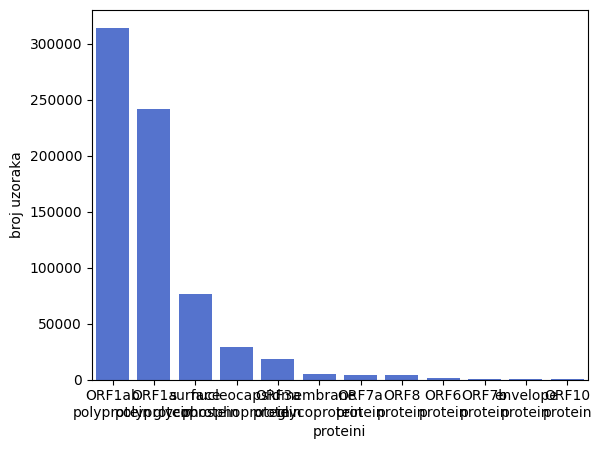

In [ ]:
# _ = plt.figure(figsize=(16, 12))

ax = sns.barplot(x=[a.replace(' ', '\n') for a in proteins.index], y=proteins[:], color='royalblue')
ax.set(xlabel='proteini', ylabel='broj uzoraka')

plt.show()

### t-SNE

Stohastičko umetanje suseda sa t-raspodelim, kraće t-SNE, je nelinearni algoritam za dimenzionu redukciju.
Važna osobina algoritma je da čuva relativna rastojanja, tako da slične podatke sa velikom verovatnoćom projektuje u tačke koje se nalaze međusobno blizu, a različite podatke daleko.
Na žalost, zbog svoje stohastičke prirode, ovaj algoritam je pogodan samo za vizualizaciju podataka.

Laurens van der Maaten je u svom radu preporučio da za parametar *perplexity* biramo vrednosti između 5 i 50.
Manje vrednosti previše naglašavaju lokalne strukture u podacima, dok veće vrednosti naglašavaju globalne strukture.
Pored toga, da bi algoritam konvergirao, neophodno je da dozvolimo veliki broj iteracija.
Zbog visoke dimenzionalnosti podataka biramo *Menhetn* rastojanje.

In [ ]:
tsne = TSNE(n_components=2,
            perplexity=50,
            exaggeration=4,
            n_iter=10000,
            early_exaggeration_iter=1000,
            n_jobs=-1, metric='manhattan',
            learning_rate='auto',
            initialization='random',
            random_state=seed)

X_train_tsne = tsne.fit(X_train.to_numpy())

Klase se izdvajaju bez preklapanja, što je ohrabrujući rezultat i obećava dobru klasifikaciju.

Možemo primetiti da se unutar pojedinih klasa formira više klastera.
Takvo ponašanje može imati više uzroka.
Jedna od mogućnosti je da unutar tih klasa postoje podklase, odnosno podtipovi proteina.
Ispitivanje postojanja podtipova proteina zahteva dodatno domensko znanje i sprovođenje dodatnih eksperimenata iz klaster analize, što izlazi iz okvira ovog rada.

Zadovoljićemo se činjenicom da se klase dobro izdvajaju bez preklapanja instanci.

c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


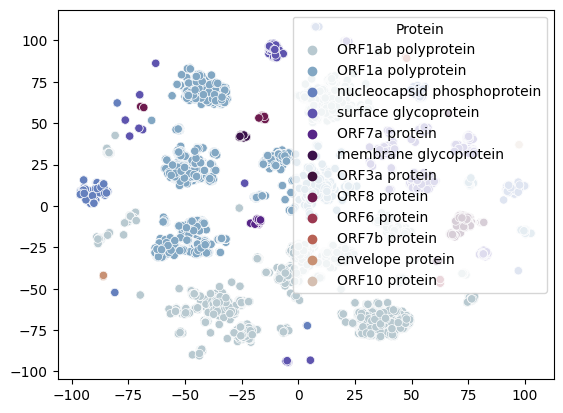

In [ ]:
# _ = plt.figure(figsize=(16, 12))

ax = sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette='twilight') # palette='plasma'
# ax.set(xlabel='', ylabel='')

plt.show()

## Treniranje i evaluacija modela

Za isbor modela koristićemo unakrsnu validaciju sa iscrpnom pretragom.
Za svaki algoritam određujemo skup parametara u kome smatramo da se nalaze parametri za optimalan model.
Trening podaci se dele na više svitaka, tako da za određenu kombinaciju parametara jedan svitak se koristi za validaciju, a ostali za trening.
Skupovi sa validaciju su u lokalnom smislu test skupovi.
Na kraju, na osnovu zadate metrike, bira se najbolji model.
Izbor metrike može znatno uticati na kvalitet modela.

Za sve algoritme, u unakrsnoj validaciji ćemo koristiti metriku balansirane tačnosti.

Obična tačnost se računa kao $\frac{broj\_tačno\_klasifikovanih\_instanci}{ukupan\_broj\_instanci}$ .
To ne daje validan rezultat u slučaju neuravnoteženih podataka.
U podacima sa kojima raspolažemo imamo 12 klasa, dok najveći broj instanci se nalazi u dve klase.
Model koji dobro klasifikuje samo te dve klase će biti dobro ocenjen, čak ako instance preostalih deset klasa klasifikuje pogrešno.

Balansirana tačnost računa tačnost za svaku klasu po formuli $\frac{broj\_tačno\_klasifikovanih\_instanci\_klase}{ukupan\_broj\_instanci\_dane\_klase}$ .
Nakon izračunavanja tačnosti za sve klase, uzima se njihov prosek i ta vrednost je balansirana tačnost datog modela.
Zapravo, dobijamo prosek odziva po klasama.
Na taj način je eliminisan uticaj neuravnoteženosti podataka.

In [19]:
protein_labels = proteins.index
labels2display = np.array([a.split(' ', 1)[0] for a in protein_labels])

In [63]:
def plot_feature_importances(clf, X, y, protein, n_repeats=4, n_jobs=1):
    if X.shape[0] > 0:
        if X.shape[0] > 196608:
            X = X.join(y, validate='one_to_one')
            X = X.groupby('Protein',group_keys=False).sample(frac=196608/X.shape[0], random_state=seed)
            X = X.reset_index(drop=True)
            y = X['Protein']
            X = X.drop(columns='Protein')
        imp_vals = permutation_importance(clf, X, y,
                                          scoring='balanced_accuracy',
                                          n_repeats=n_repeats,
                                          n_jobs=n_jobs,
                                          random_state=seed)
        df_pi = pd.DataFrame({'feature_name': X.columns, 'feature_importance': imp_vals.importances_mean})
        # plt.figure(figsize=(16, 4))
        # ax = sns.barplot(df_fi.sort_values(by=['feature_importance'], ascending=False)
        #                  .head(),
        #                  x='feature_importance', y='feature_name') # opadajuce sortirani atributi
        ax = sns.barplot(df_pi.reindex(df_pi['feature_importance'].abs()
                                       .sort_values(ascending=False)
                                       .index).head(4),
                         x='feature_importance', y='feature_name')  # apsolutno opadajuce sortirani atributi
        ax.set(xlabel='znacaj atributa', ylabel='atribut')
        plt.title(protein)
        plt.show()

### Komplementarni naivni Bajesov algoritam

Naivni Bajesov algoritam funkcioniše tako što izračunava verovatnoću da instanca pripada određenoj klasi sa zadatom kombinacijom atributa.
Komplementarna varijacija algoritma računa verovatnoću da instanca ne pripada klasi i dodeljuje je onoj klasi sa najmanjom izračunatom verovatnoćom nepripadnosti.
Autori algoritma tvrde da se na taj način umanjuje uticaj neuravnoteženosti podataka.

U implementaciji je ugrađen i algoriam za aditivno uglađivanje podataka koji prima *alpha* parametar.
U idealnom slučaju, za parametar *alpha* bi isprobali vektore sa svim varijacije sa ponavljanjem nekog skupa vrednosti, kako bi našli optimalne vrednosti za svaki atribut.
Takva pretraga bi bila eksponencijalne složenosti, pa bi svrsishodnije bilo isprobati drugi algoritam ukoliko ovaj ne da željene rezultate.

In [21]:
params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000, 10000]}]

In [22]:
clf = GridSearchCV(ComplementNB(), params, scoring='balanced_accuracy', n_jobs=-1, cv=8)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela.

In [23]:
clf.best_score_

0.540277397229857

Parametri najboljeg modela.

In [24]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

alpha
0.000010


Izveštaj za trening skup.
Metrike kao što je tačnost ocenjuju da je ovaj model dobar.
Model ispravno klasifikuje samo podatke iz zastupljenijih klasa, dok ostale klase potpuno pogrešno klasifikuje.
Obična metrika tačnost takvu razliku ne primećuje, jer je najveći broj instanci pravilno klasifikovan.

In [25]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000       364
          ORF1a polyprotein    0.99994   1.00000   0.99997    241372
         ORF1ab polyprotein    0.99518   1.00000   0.99759    314439
              ORF3a protein    0.93516   1.00000   0.96649     18476
               ORF6 protein    0.00000   0.00000   0.00000      1098
              ORF7a protein    1.00000   0.87097   0.93103      3937
              ORF7b protein    0.00000   0.00000   0.00000       743
               ORF8 protein    1.00000   0.61159   0.75899      3831
           envelope protein    0.00000   0.00000   0.00000       658
      membrane glycoprotein    0.00000   0.00000   0.00000      5083
nucleocapsid phosphoprotein    0.82896   1.00000   0.90648     29103
       surface glycoprotein    0.98562   1.00000   0.99276     76782

                   accuracy                        0.98571    695886
                  macro avg    0

Vrednosti u matrici konfuzije su normalizovane po redovima prema klasi kojoj zaista pripadaju.
Ukoliko imamo instance klase *i* klasifikovane kao instance klase *j* tada će i matrici konfuzije na poziciji *(i, j)* biti vrednost $C_{i, j}$.
$$
C_{i, j} = \frac{broj\_instanci\_klase\_i\_klasifikovanih\_kao\_instance\_klase\_j}{ukupan\_broj\_instanci\_klase\_i}
$$
Na taj način eliminišemo konfuziju koja nastaje usled neuravnoteženih podataka i naglašavamo koliko podataka iz neke klase je pravilno klasifikovano i koje klase klasifikator meša.

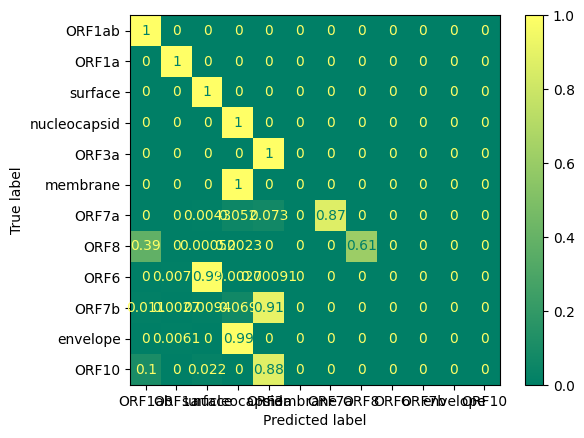

In [26]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

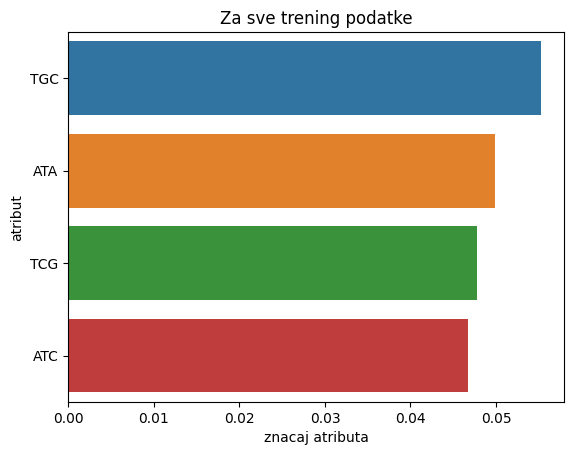

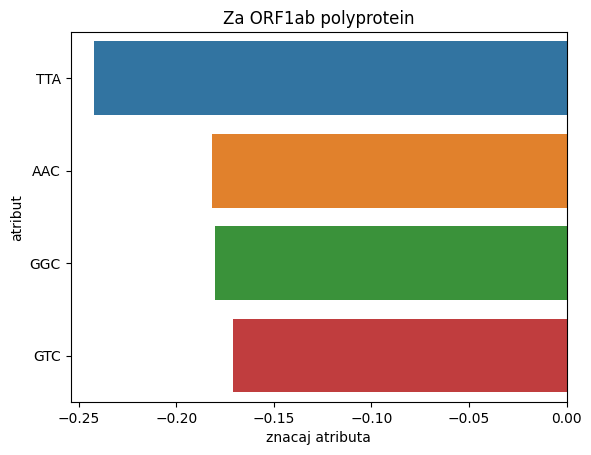

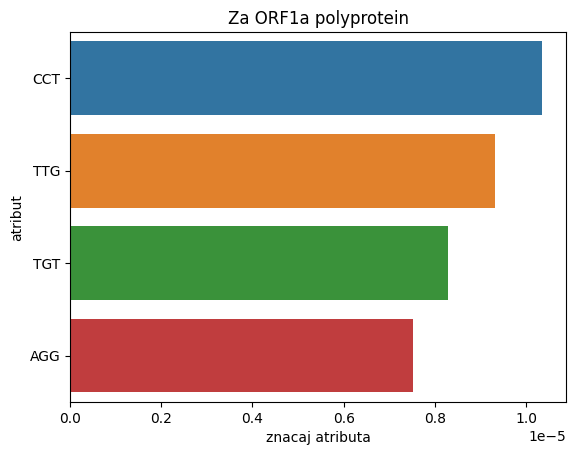

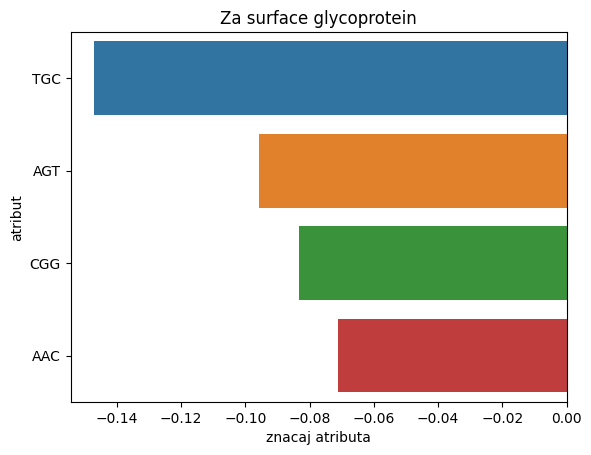

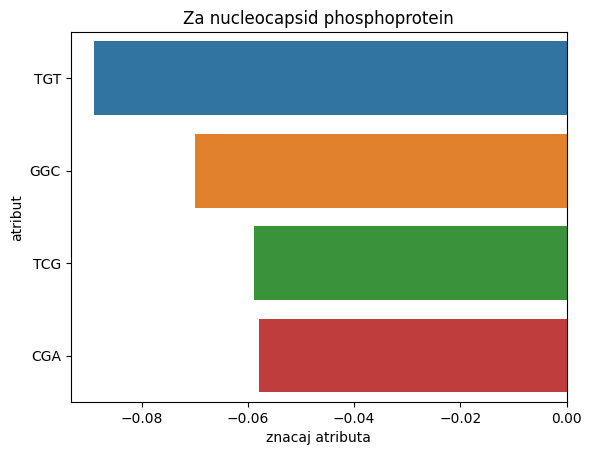

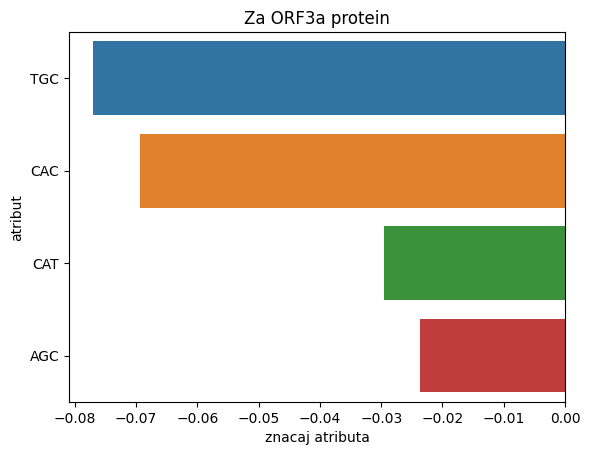

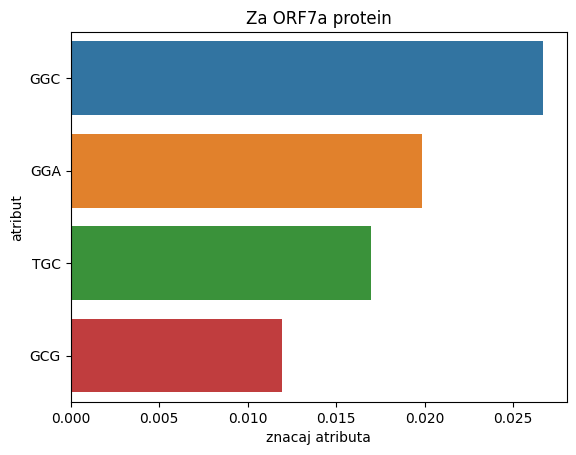

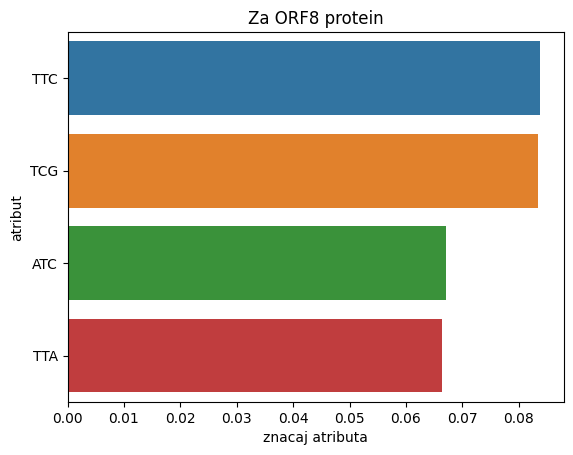

In [27]:
plot_feature_importances(clf, X_train, y_train,
                         'Za trening podatke', n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_train[y_pred == protein],
                             y_train[y_pred == protein],
                             f'Za {protein}', n_jobs=-1)

Izveštaj za test skup.

In [28]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000        91
          ORF1a polyprotein    0.99992   1.00000   0.99996     60343
         ORF1ab polyprotein    0.99485   1.00000   0.99742     78610
              ORF3a protein    0.93483   1.00000   0.96632      4619
               ORF6 protein    0.00000   0.00000   0.00000       274
              ORF7a protein    1.00000   0.86585   0.92810       984
              ORF7b protein    0.00000   0.00000   0.00000       186
               ORF8 protein    1.00000   0.58768   0.74030       958
           envelope protein    0.00000   0.00000   0.00000       164
      membrane glycoprotein    0.00000   0.00000   0.00000      1271
nucleocapsid phosphoprotein    0.82946   1.00000   0.90678      7276
       surface glycoprotein    0.98547   1.00000   0.99268     19196

                   accuracy                        0.98556    173972
                  macro avg    0

Dobijeni model uopšte nije impresivan.
Očigledno je potprilagođen.
Polovinu klasa potpuno pogrešno klasifikuje.
Za utehu, ponašanje je konzistentno i na trening in na test skupu.

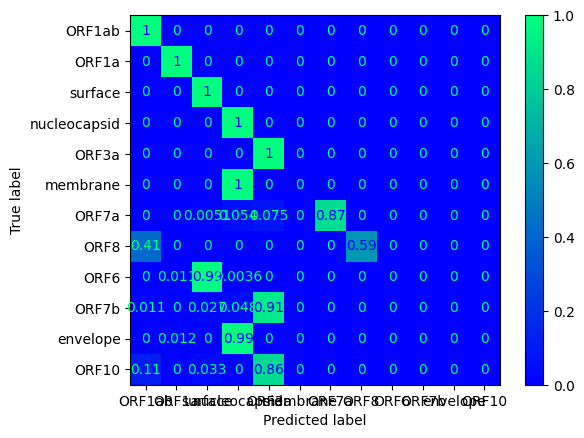

In [29]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

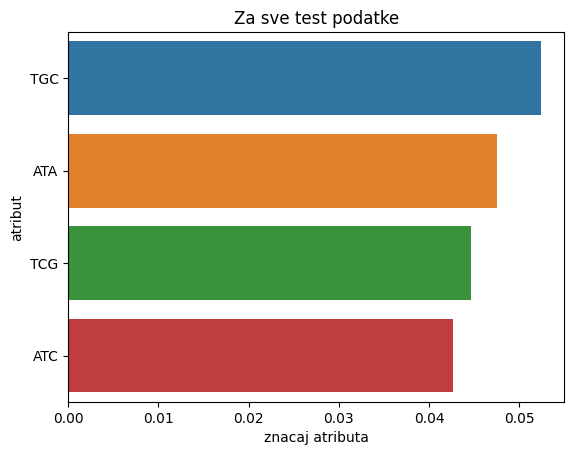

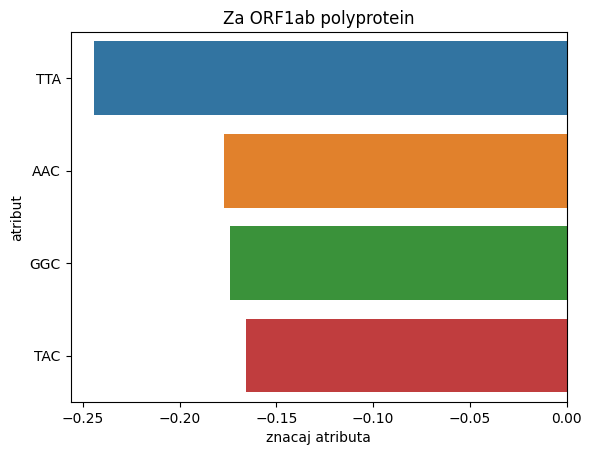

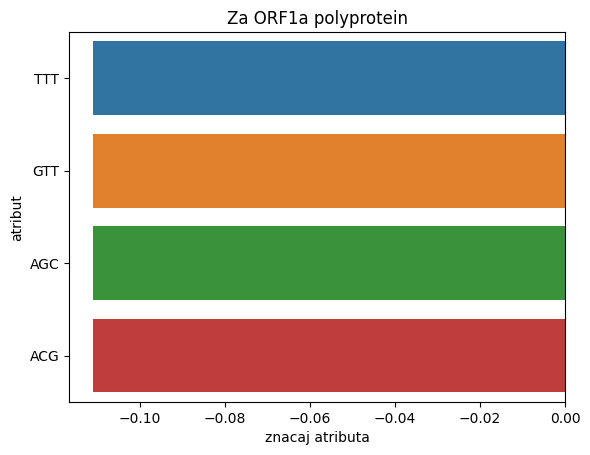

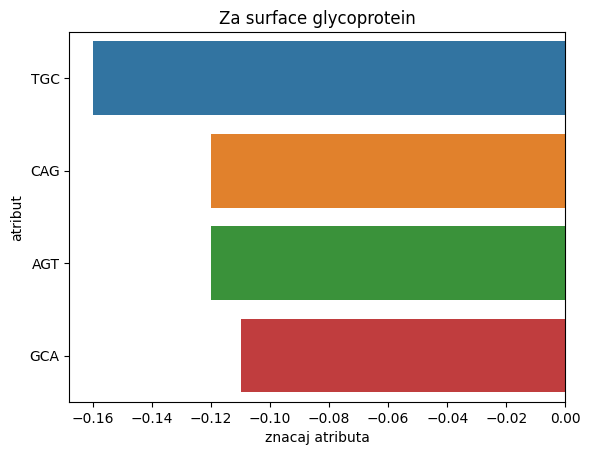

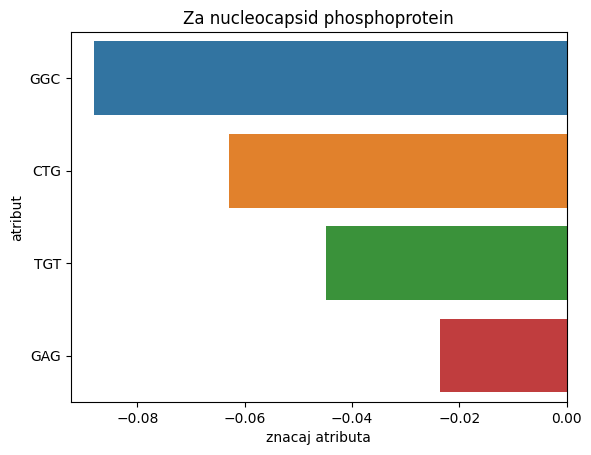

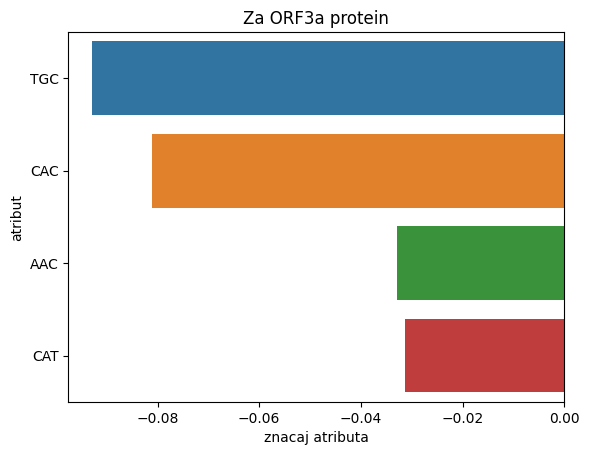

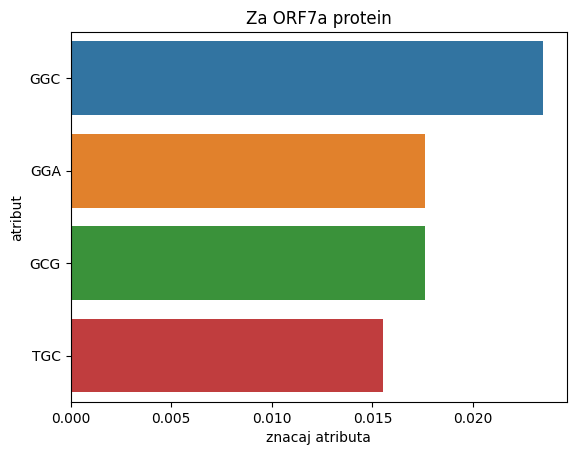

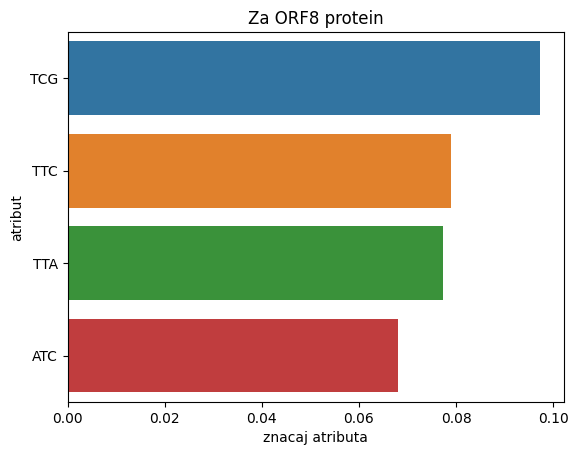

In [30]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke', n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}', n_jobs=-1)

### Pakovanje naivnog Bajesovog algoritma

Rezultati koje je dao naivni Bajesov algoritam nisu bili impresivni, ali da li možemo da ih popravimo metodama ansambla?
Pakovanje je metoda ansambla koja koristi više slabih klasifikatora koji se obično ne obučavaju nad celim skupom podataka, već nad nasumičnim uzorcima sa ponavljanjem.
Algoritam dodeljuje instanci onu klasu koju je izabrao najveći broj klasifikatora.

Probaćemo sa različitim brojem klasifikatora i različitim maksimalnim veličinama uzorka.

In [31]:
params = [{'estimator': [ComplementNB()],
           'n_estimators': [64, 128, 256],
           'max_samples': [0.01, 0.1, 0.2],
           'n_jobs': [-1],
           'random_state': [seed]}]

In [32]:
clf = GridSearchCV(BaggingClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela.

In [33]:
clf.best_score_

0.5412091804738266

Parametri najboljeg modela.

In [34]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

estimator,max_samples,n_estimators,n_jobs,random_state
ComplementNB(),0.100000,128,-1,196883


Izveštaj za trening skup.

In [35]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000       364
          ORF1a polyprotein    0.99994   1.00000   0.99997    241372
         ORF1ab polyprotein    0.99536   1.00000   0.99768    314439
              ORF3a protein    0.93445   1.00000   0.96612     18476
               ORF6 protein    0.00000   0.00000   0.00000      1098
              ORF7a protein    1.00000   0.86614   0.92827      3937
              ORF7b protein    0.00000   0.00000   0.00000       743
               ORF8 protein    1.00000   0.62595   0.76995      3831
           envelope protein    0.00000   0.00000   0.00000       658
      membrane glycoprotein    0.00000   0.00000   0.00000      5083
nucleocapsid phosphoprotein    0.82884   1.00000   0.90641     29103
       surface glycoprotein    0.98561   1.00000   0.99275     76782

                   accuracy                        0.98576    695886
                  macro avg    0

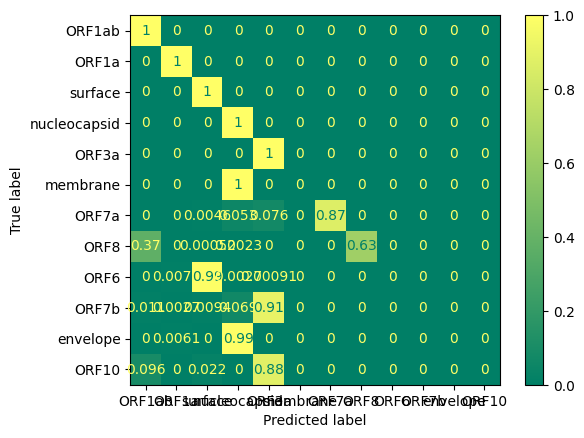

In [36]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

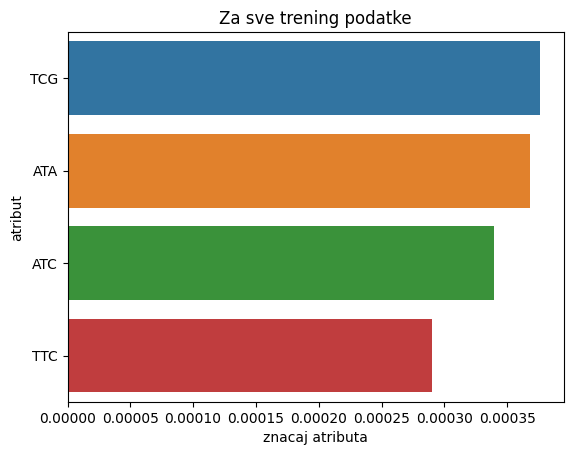

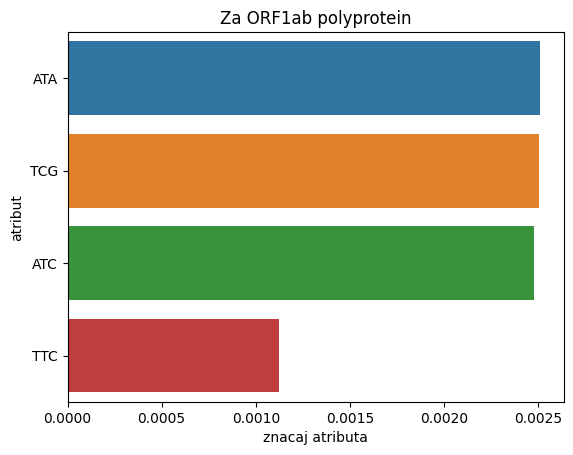

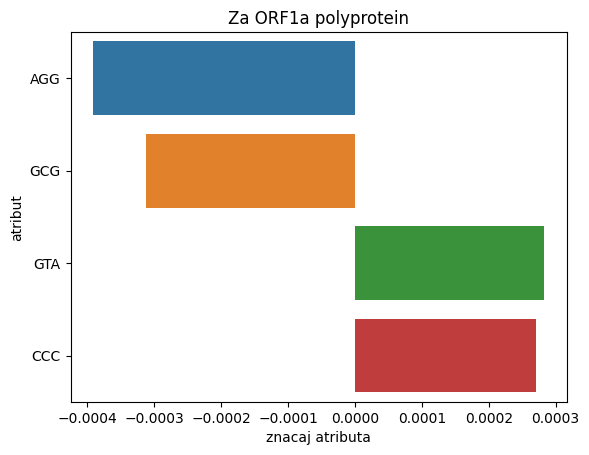

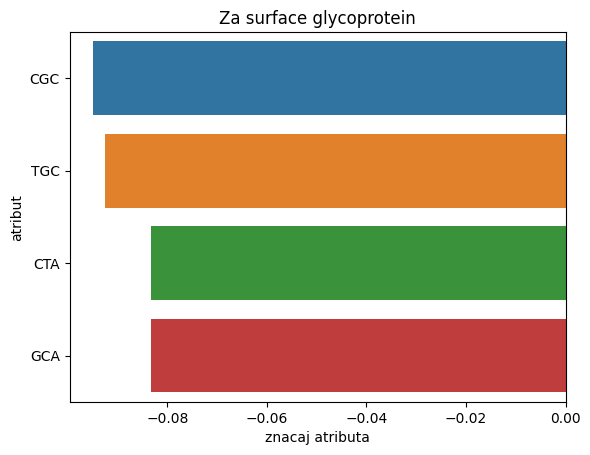

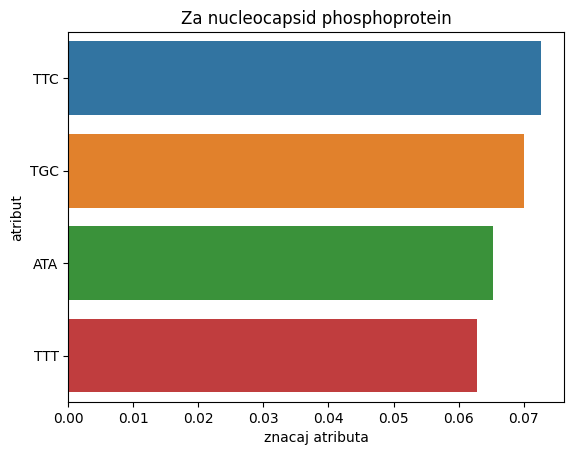

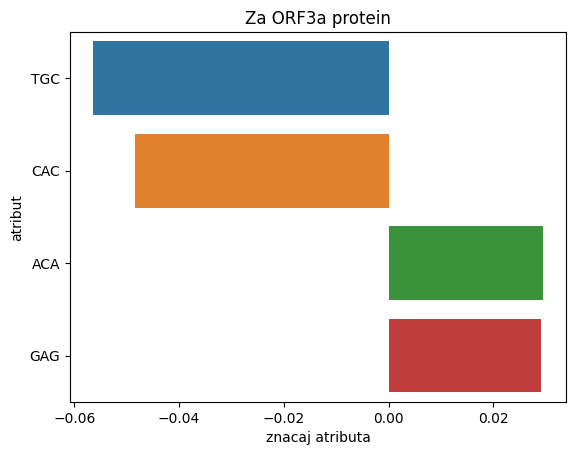

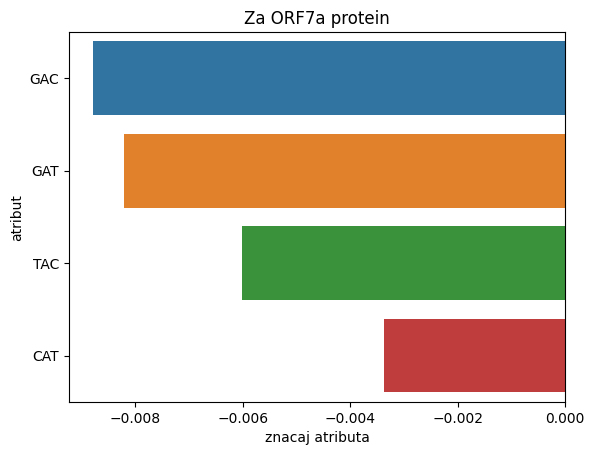

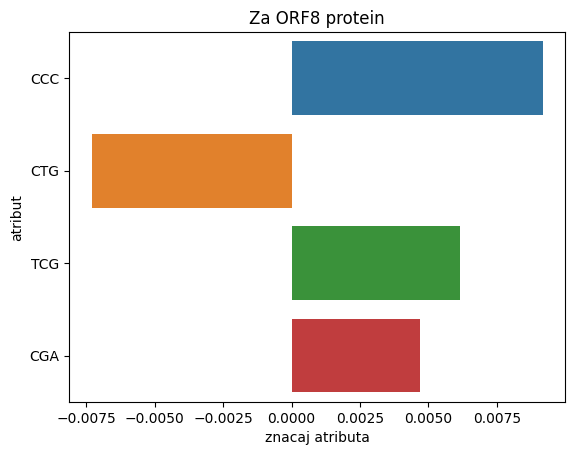

In [70]:
plot_feature_importances(clf, X_train, y_train,
                         'Za trening podatke',
                         n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_train[y_pred == protein],
                             y_train[y_pred == protein],
                             f'Za {protein}', n_jobs=2)

Izveštaj za test skup.

In [71]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000        91
          ORF1a polyprotein    0.99992   1.00000   0.99996     60343
         ORF1ab polyprotein    0.99501   1.00000   0.99750     78610
              ORF3a protein    0.93389   1.00000   0.96581      4619
               ORF6 protein    0.00000   0.00000   0.00000       274
              ORF7a protein    1.00000   0.85976   0.92459       984
              ORF7b protein    0.00000   0.00000   0.00000       186
               ORF8 protein    1.00000   0.60125   0.75098       958
           envelope protein    0.00000   0.00000   0.00000       164
      membrane glycoprotein    0.00000   0.00000   0.00000      1271
nucleocapsid phosphoprotein    0.82946   1.00000   0.90678      7276
       surface glycoprotein    0.98542   1.00000   0.99266     19196

                   accuracy                        0.98560    173972
                  macro avg    0

Ni pakovanje nije pomoglo da dobijemo bolji klasifikator zasnovan na naivnom Bajesovom algoritmu.

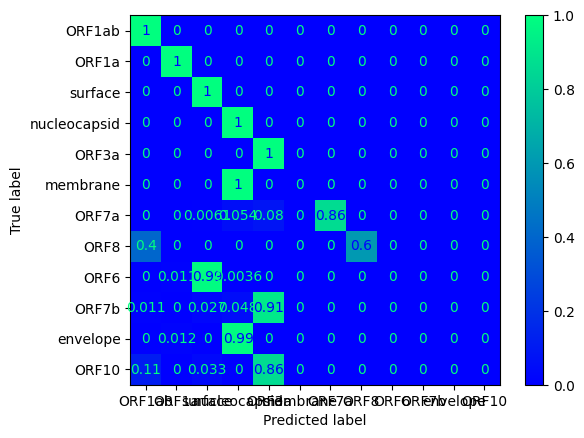

In [72]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

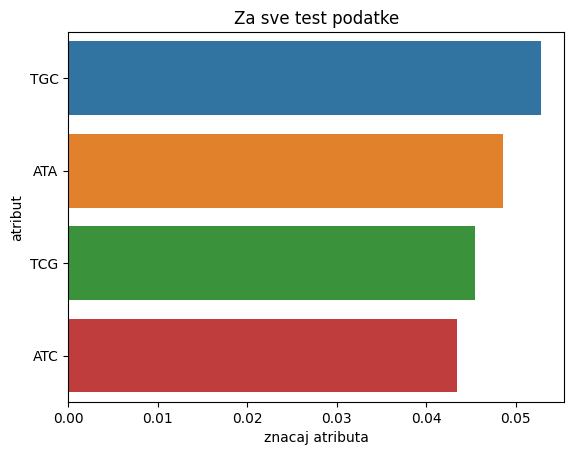

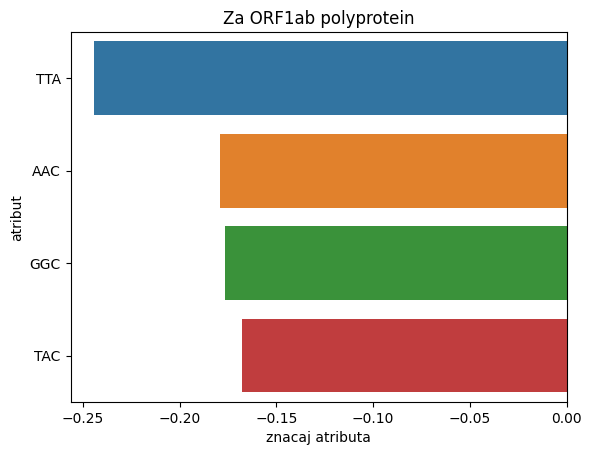

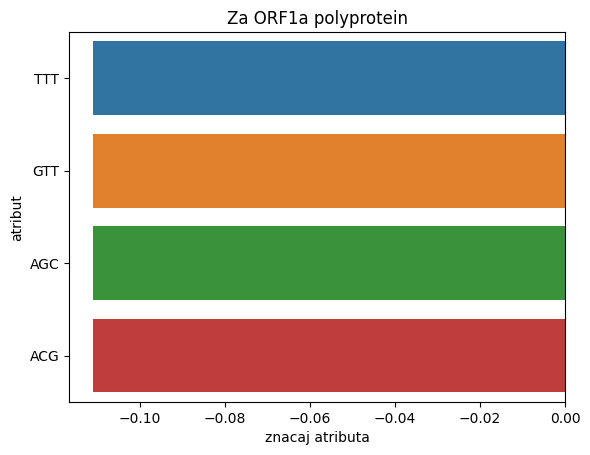

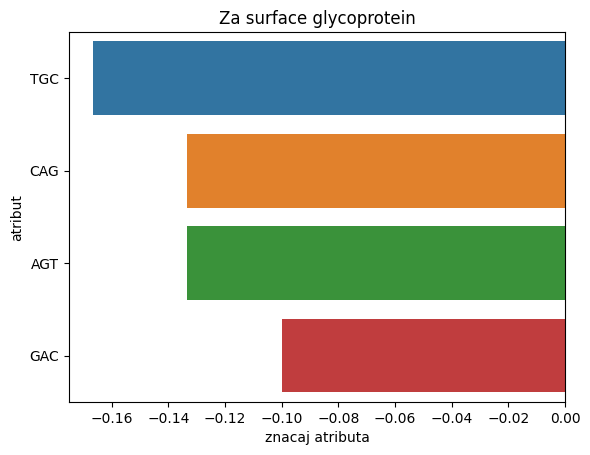

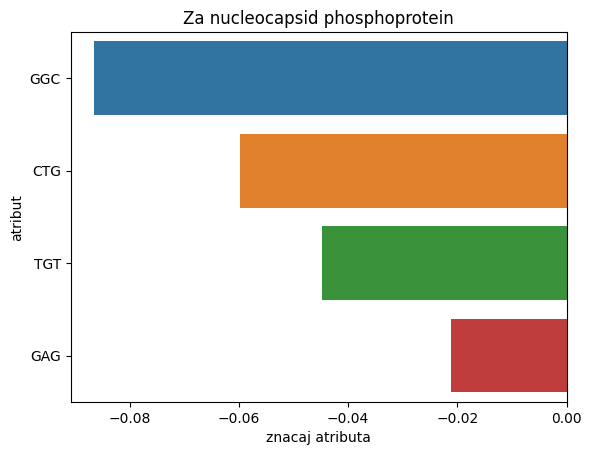

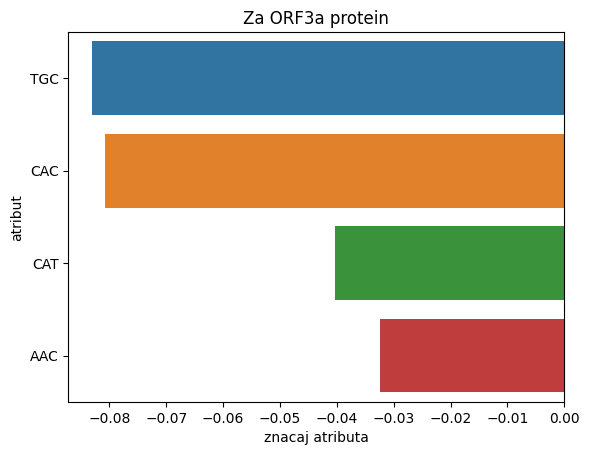

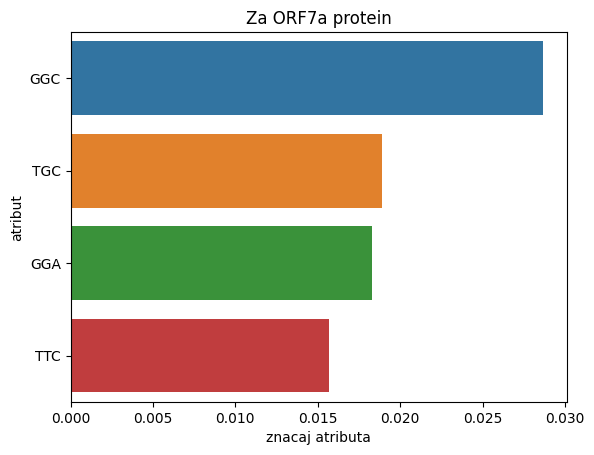

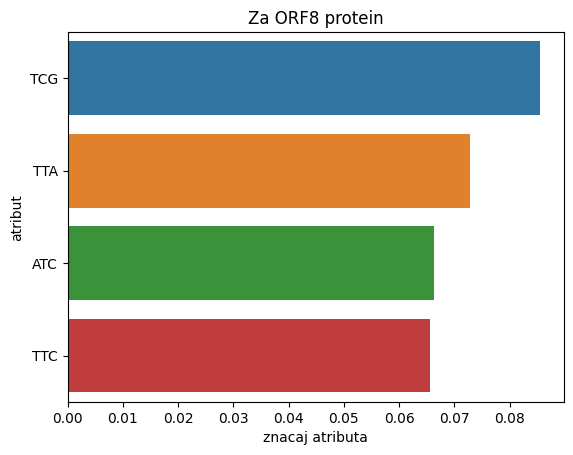

In [75]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke')

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}')

### Drvo odlučivanja

Naivni Bajesov algoritam nije dao značajne rezultate.
Vreme je da isprobamo nešto potpuno drugačije.
Algoritam CART.

Izabraćemo dva pristupa za unakrsnu validaciju.
U jednom ćemo varirati parametre za maksimalnu dubinu drveta i minimalan broj uzoraka u čvoru za podelu i list.
U drugom pristupu umesto konstantnih ograničenja, koristićemo minimalno smanjenje nečistoće za podelu i potkresivanje.
U oba slučaja proveravaćemo da li ginijev indeks ili entropija daju bolje rezultate za informacionu dobit.

In [76]:
params = [{'criterion': ['gini', 'entropy'],
            'max_depth': [4, 8, 16, 32],
            'min_samples_split': [128, 256],
            'min_samples_leaf': [32, 64],
            'class_weight': ['balanced'],
            'random_state': [seed]},
          {'criterion': ['gini', 'entropy'],
            'min_impurity_decrease': [0.01, 0.02, 0.03, 0.04],
            'ccp_alpha': [0.01, 0.02, 0.03, 0.04],
            'class_weight': ['balanced'],
            'random_state': [seed]}]

In [77]:
clf = GridSearchCV(DecisionTreeClassifier(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela obećava.

In [78]:
clf.best_score_

0.9984184515899963

Parametri najboljeg modela.

In [79]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

class_weight,criterion,max_depth,min_samples_leaf,min_samples_split,random_state
balanced,gini,8,32,128,196883


Grafički prikaz drva odlučivanja.
Veliki listovi su čisti čvorovi i svaka klasa ima svoj veliki list.
Listovi niže čistoće sadrže dvocifrene brojeve instanci i ne zadovoljavaju kriterijume minimalnog broja instanci u čvoru za deobu ili minimalnog broja instanci u čvoru da bi bio list.

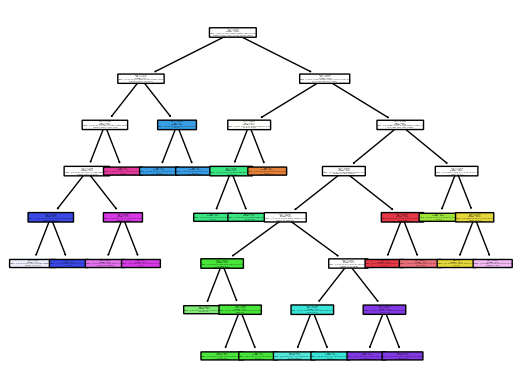

In [80]:
_ = plot_tree(clf.best_estimator_,
          rounded=True,
          filled=True,
          # impurity=False,
          proportion=True,
          precision=5,
          feature_names=X_train.columns.to_numpy(),
          class_names=list(clf.best_estimator_.classes_))

Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [81]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   0.99987   0.99994    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    0.99984   0.99989   0.99986     18476
               ORF6 protein    0.99909   0.99727   0.99818      1098
              ORF7a protein    0.99949   0.99721   0.99835      3937
              ORF7b protein    1.00000   0.99865   0.99933       743
               ORF8 protein    0.99662   1.00000   0.99831      3831
           envelope protein    0.99847   0.99392   0.99619       658
      membrane glycoprotein    0.99316   1.00000   0.99657      5083
nucleocapsid phosphoprotein    1.00000   0.99997   0.99998     29103
       surface glycoprotein    0.99997   0.99995   0.99996     76782

                   accuracy                        0.99992    695886
                  macro avg    0

Nakon naivnog Bajesovog algoritma, impresivan rezultat.

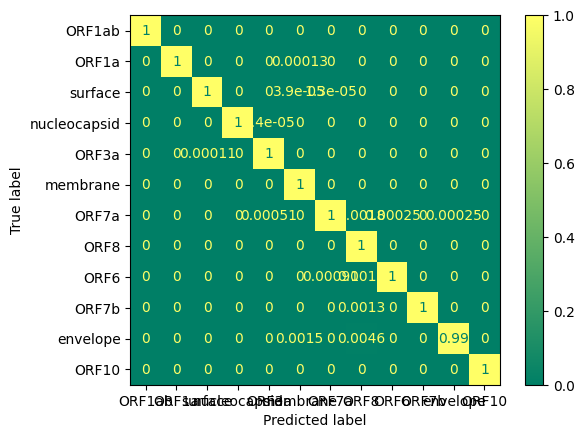

In [82]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

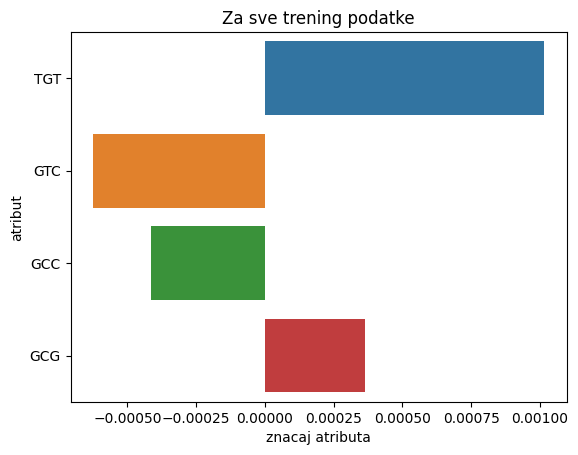

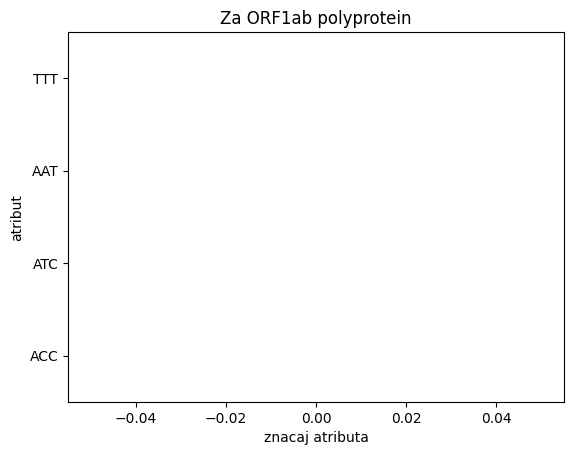

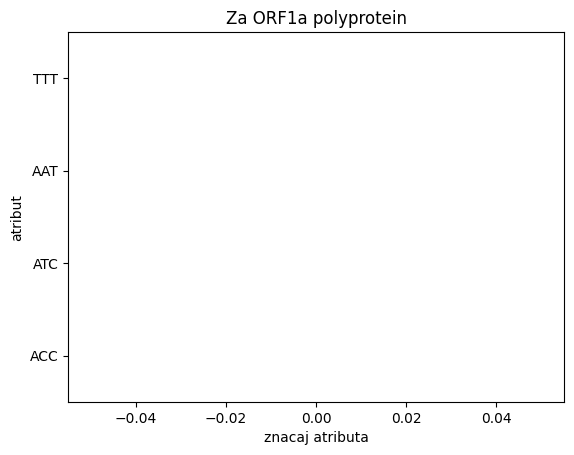

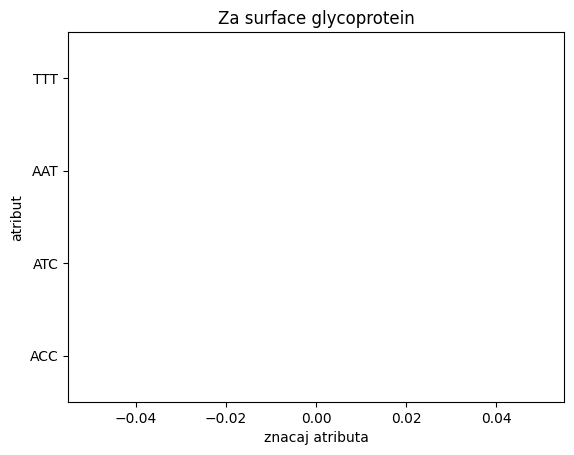

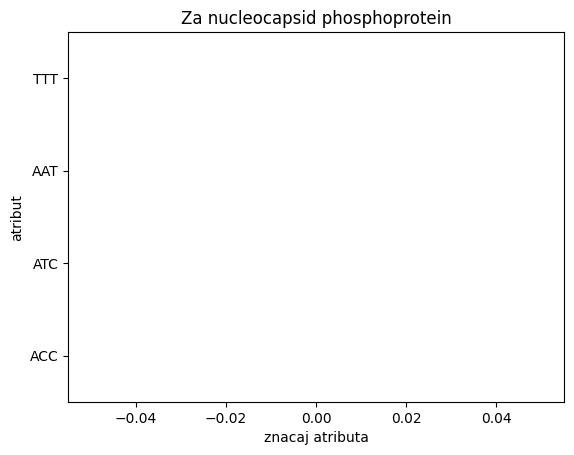

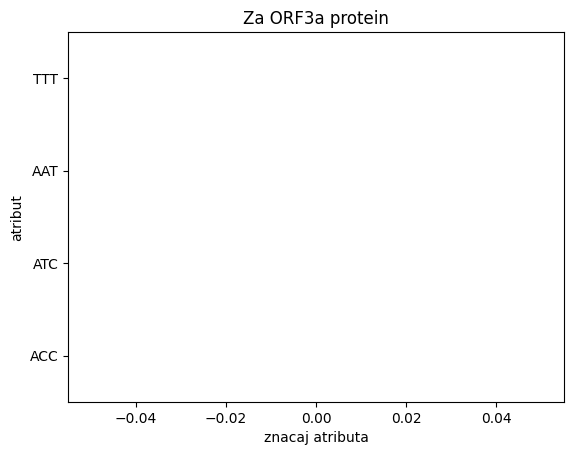

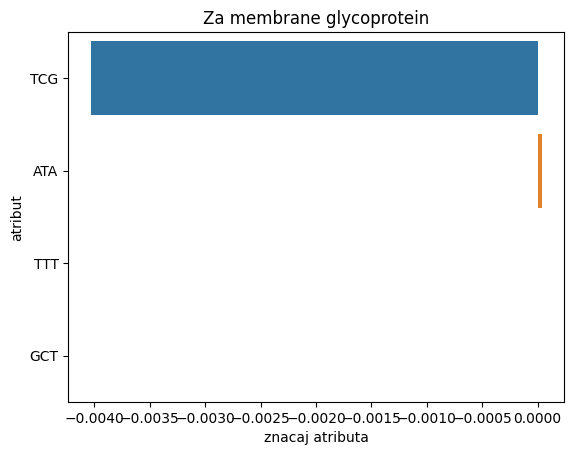

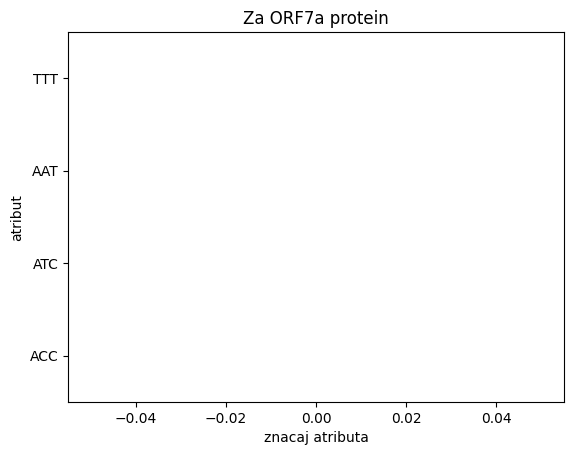

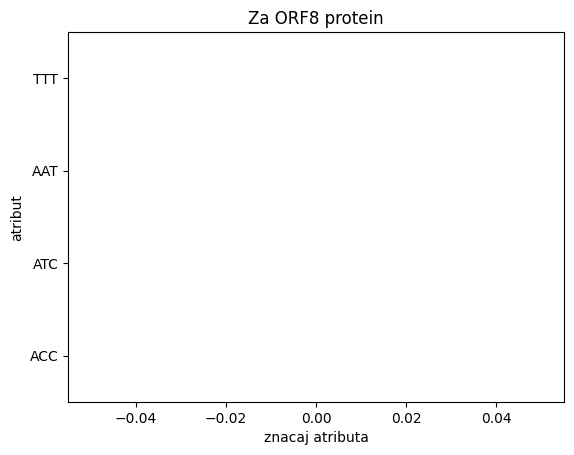

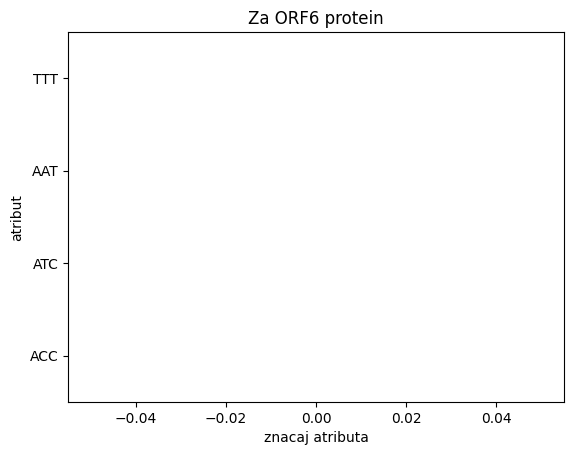

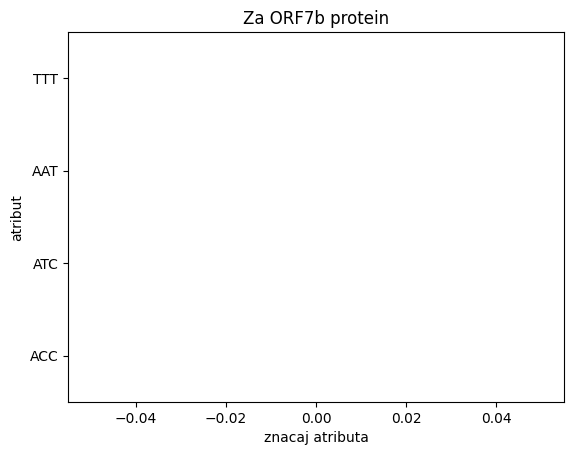

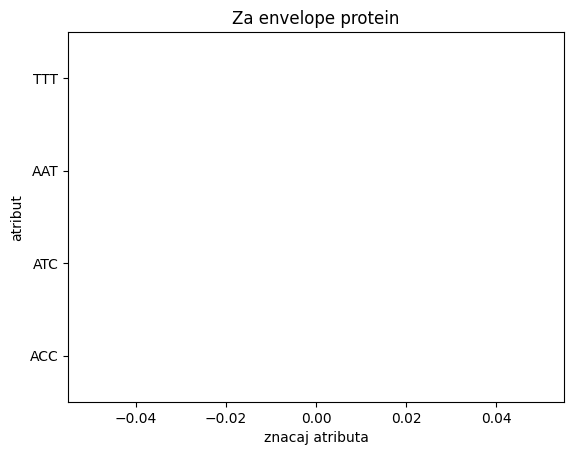

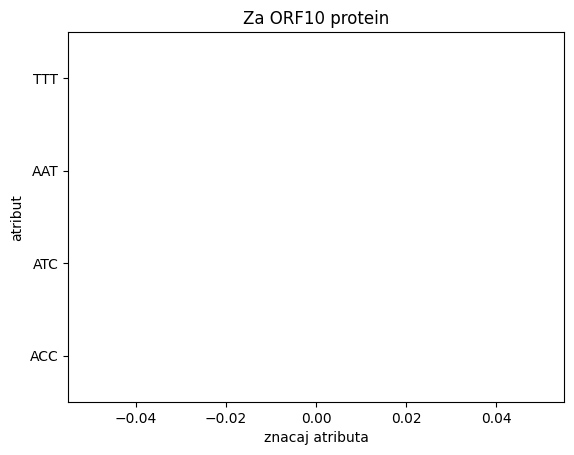

In [83]:
plot_feature_importances(clf,
                         X_train,
                         y_train,
                         'Za trening podatke',
                         n_repeats=128, n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_train[y_pred == protein],
                             y_train[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=128, n_jobs=-1)

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [84]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   0.99990   0.99995     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    0.99935   1.00000   0.99968      4619
               ORF6 protein    0.99636   1.00000   0.99818       274
              ORF7a protein    0.99898   0.99492   0.99695       984
              ORF7b protein    0.99465   1.00000   0.99732       186
               ORF8 protein    0.99687   0.99896   0.99791       958
           envelope protein    1.00000   0.98780   0.99387       164
      membrane glycoprotein    0.99530   1.00000   0.99765      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   0.99995   0.99997     19196

                   accuracy                        0.99991    173972
                  macro avg    0

Ipak, blago preprilagođen.
Ovaj model je veoma dobar, ali nije savršen.
Iako skoro sve kodirajuće sekvence pravilno klasifikuje, ipak se provuče po neka.
Vidi se iz matrice konfuzije.

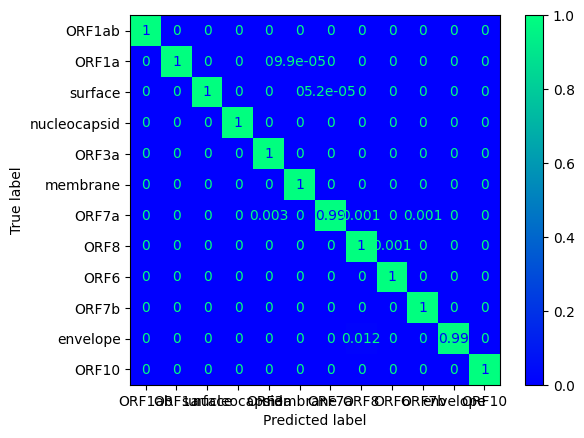

In [85]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

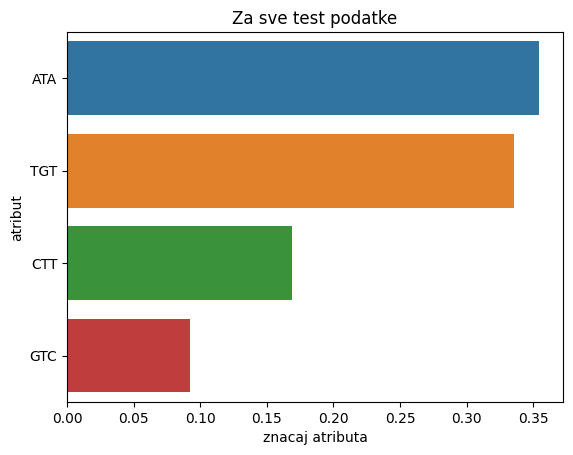

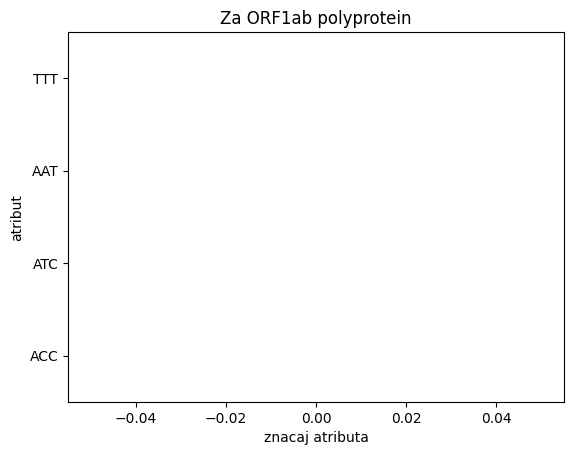

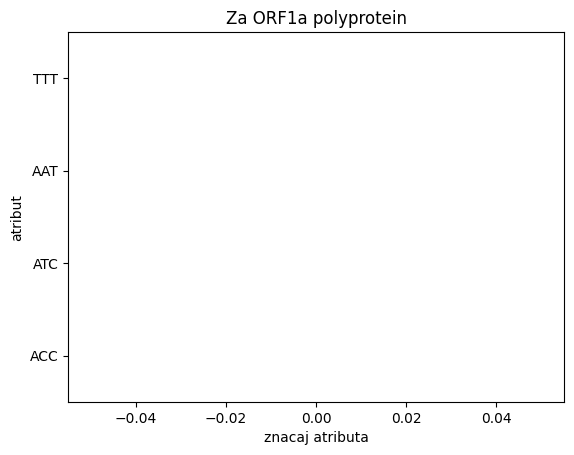

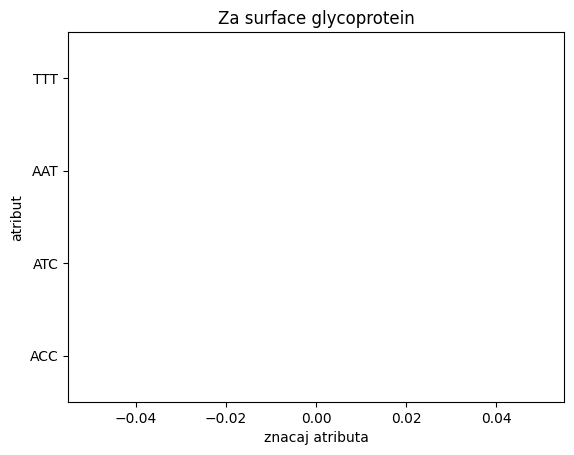

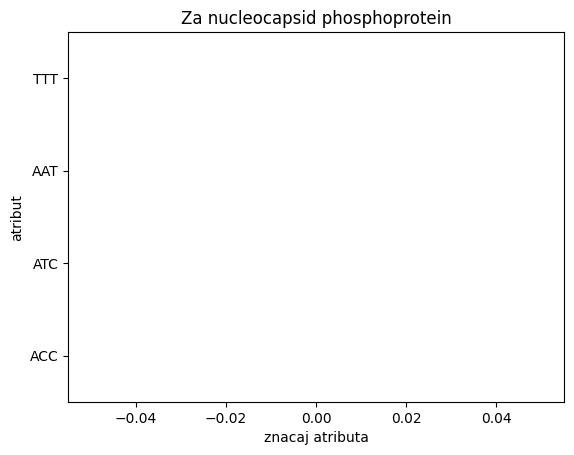

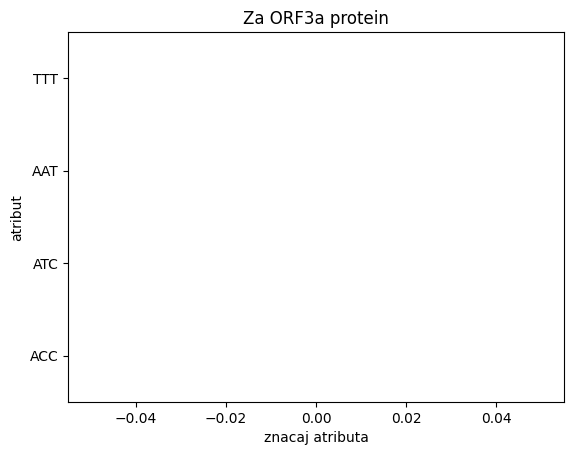

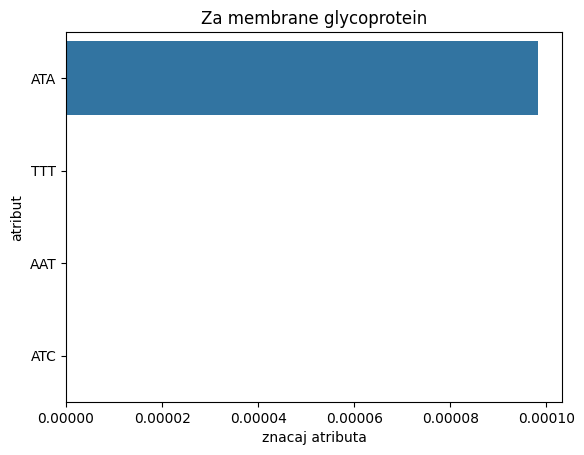

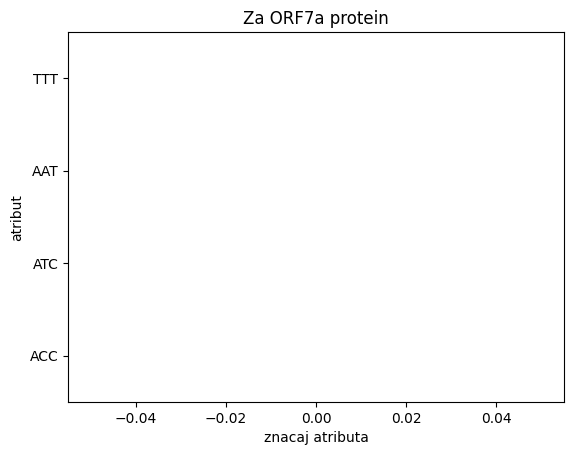

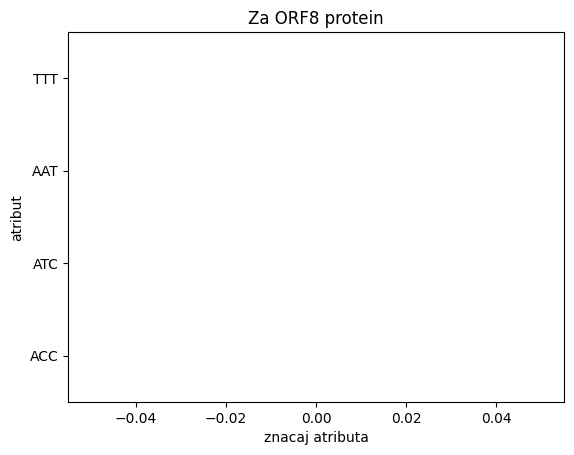

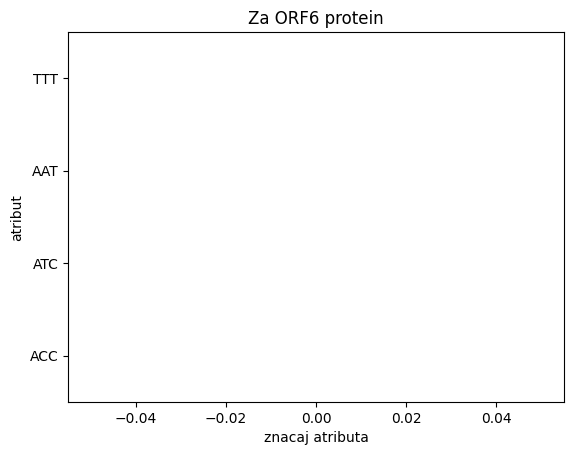

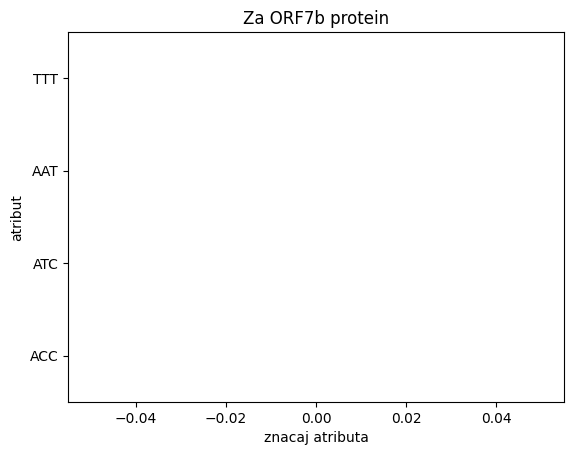

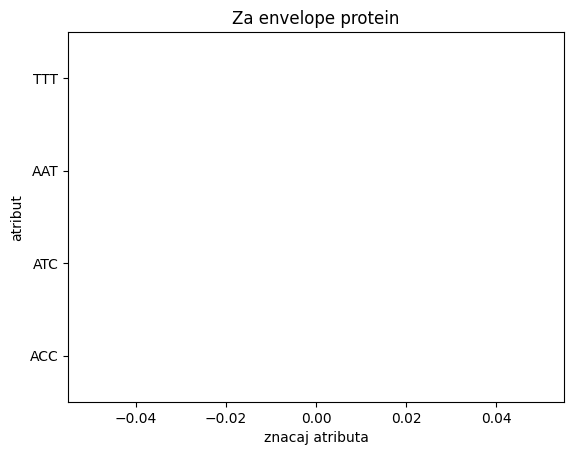

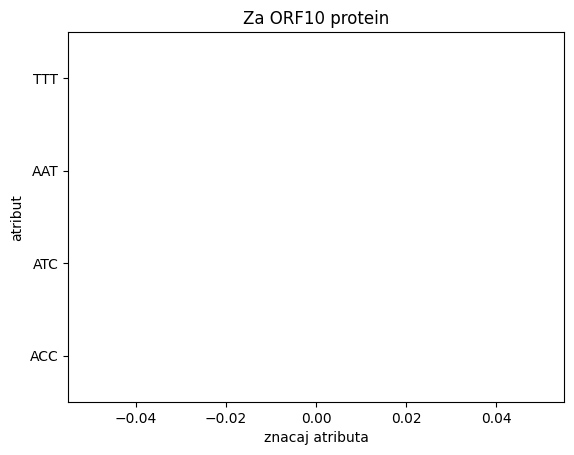

In [86]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke',
                         n_repeats=128, n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=128, n_jobs=-1)

### Nasumična šuma

Metoda slična pakovanju.
Klasifikatori su stabla odlučivanja koja se obučavaju na nasumično izabranim uzorcima atributa i instanci.
Slično kao u pakovanju, izlaz algoritma je klasa koju je izabrao najveći broj stabala odlučivanja.

Unakrsnom validacijom ćemo testirati modele sa različitim brojem klasifikatora i najvećim dozvoljenim brojevima atributa i instanci u uzorcima.
Pustićemo da se stabla preprilagode.

In [87]:
params = [{'n_estimators': [32, 64, 128, 256],
           'criterion': ['entropy'],
           'max_features': [0.4, 0.6],
           'max_samples': [0.4, 0.6],
           'n_jobs': [-1],
           'random_state': [seed]}]

In [88]:
clf = GridSearchCV(RandomForestClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela.

In [89]:
clf.best_score_

0.9999014273894076

Parametri najboljeg modela.

In [90]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

criterion,max_features,max_samples,n_estimators,n_jobs,random_state
entropy,0.400000,0.400000,128,-1,196883


Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [91]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

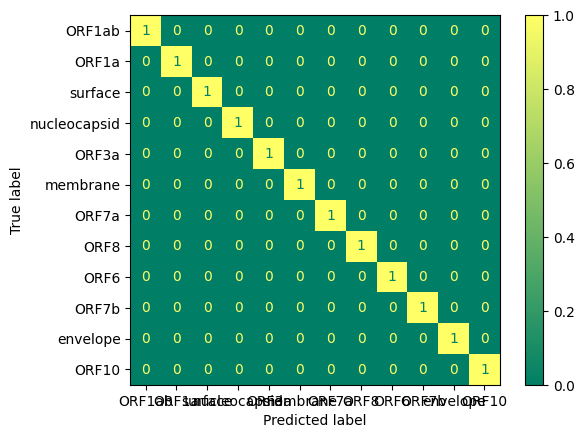

In [92]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

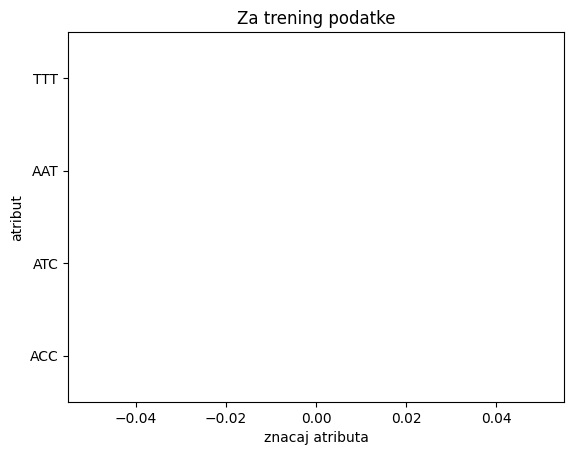

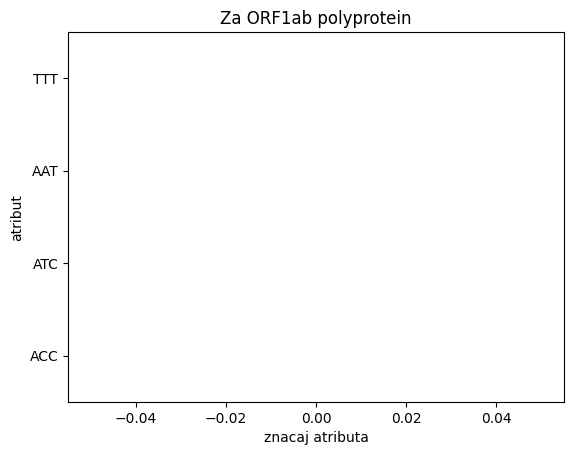

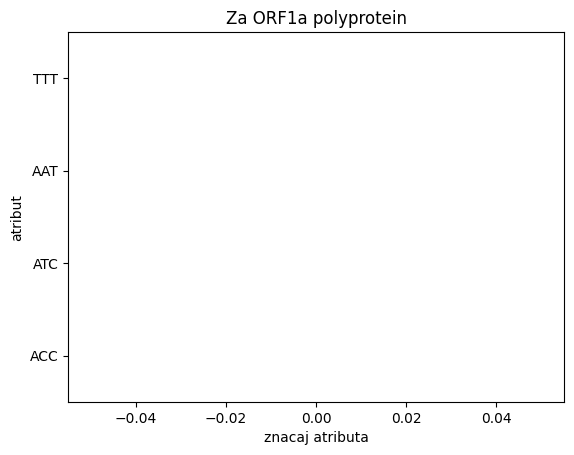

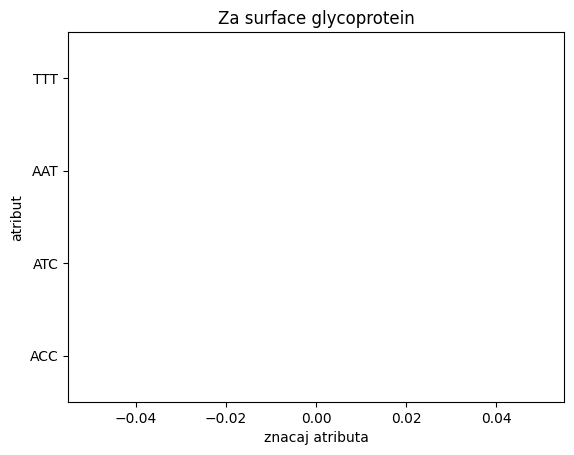

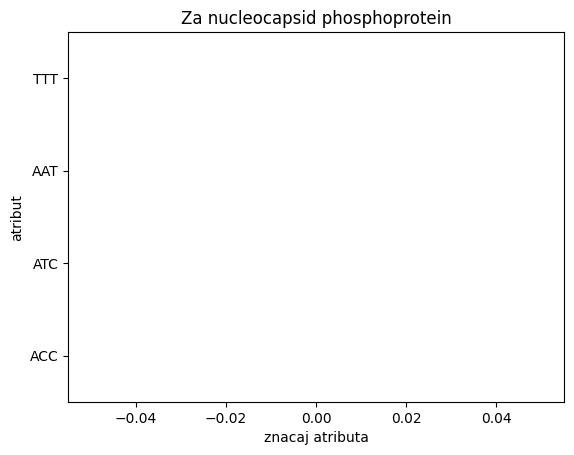

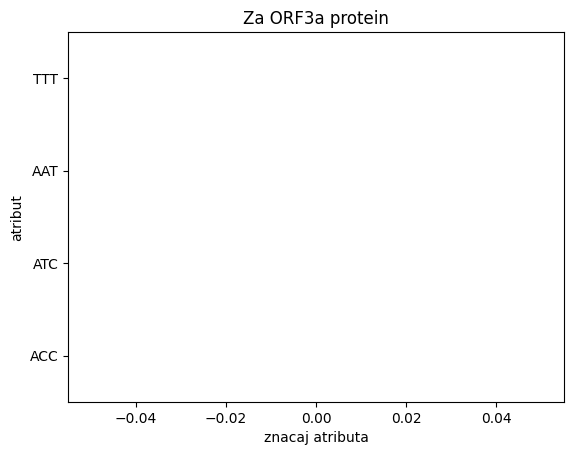

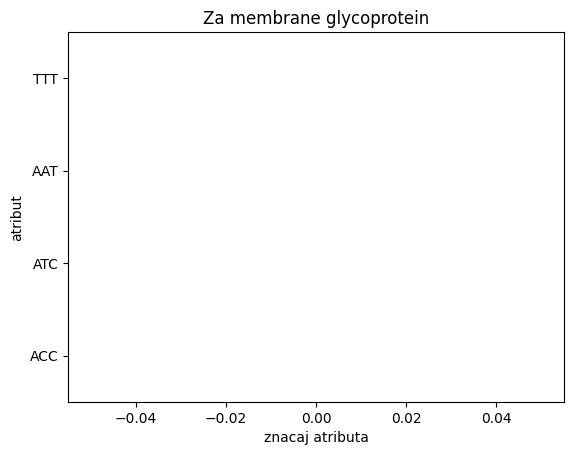

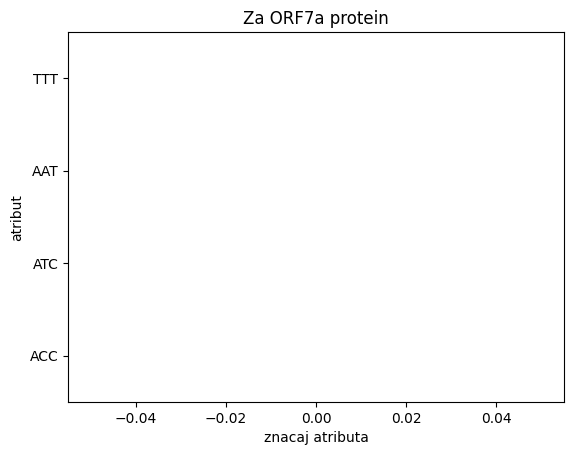

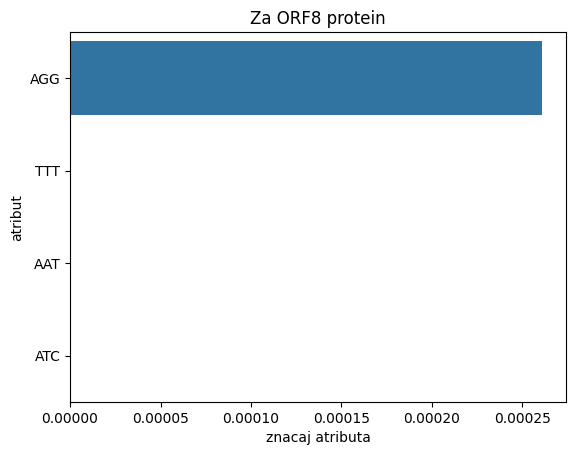

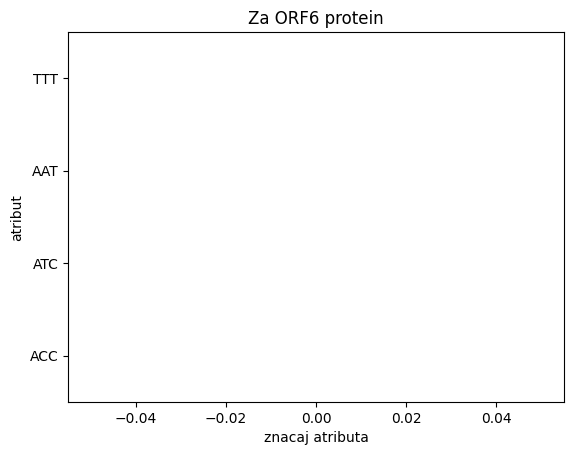

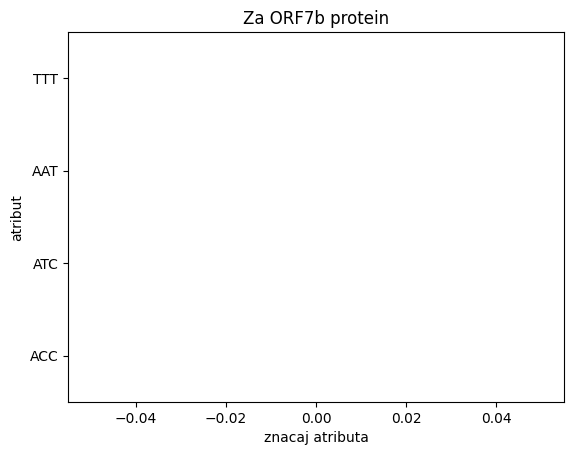

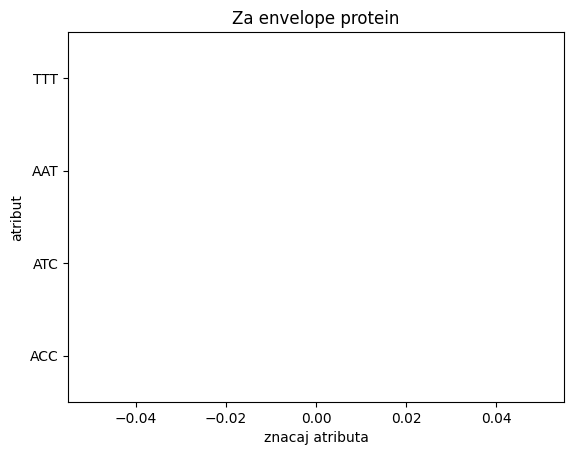

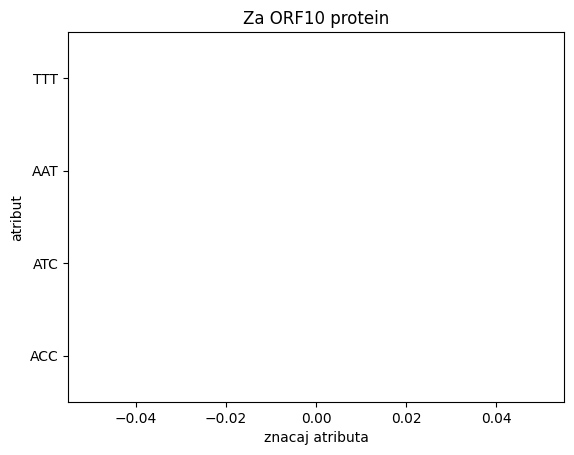

In [93]:
plot_feature_importances(clf, X_train, y_train,
                         'Za trening podatke',
                         n_repeats=32, n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_train[y_pred == protein],
                             y_train[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=32, n_jobs=2)

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [94]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        1.00000    173972
                  macro avg    1

Ovaj model je praktično savršen.

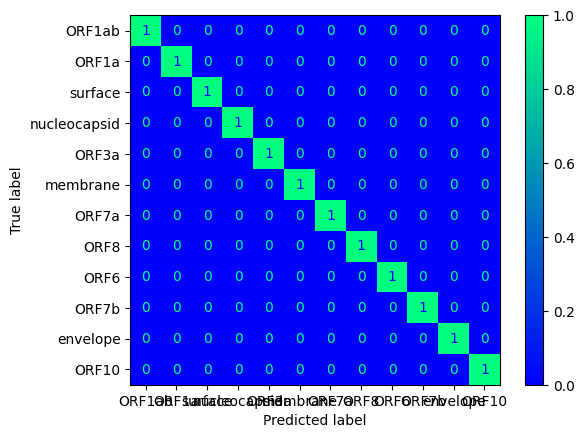

In [95]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

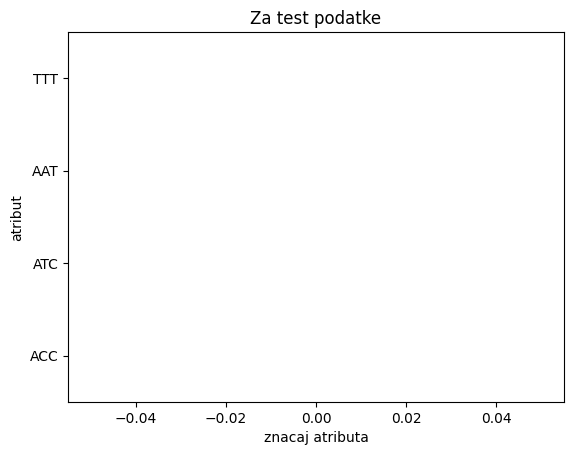

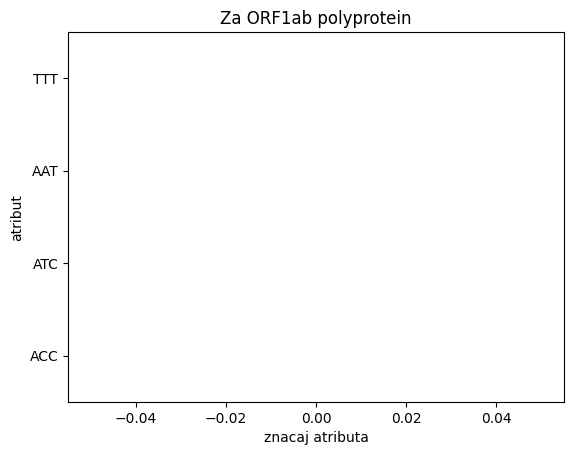

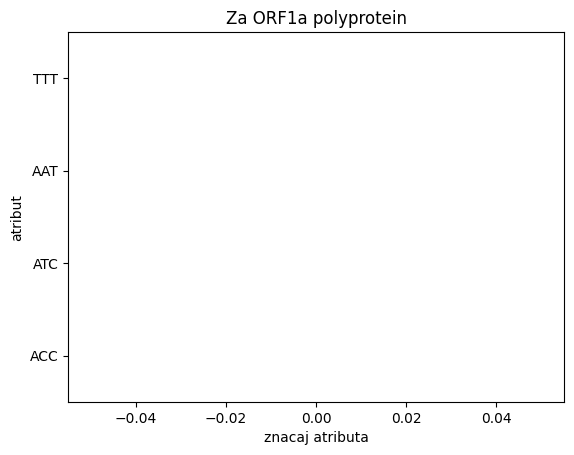

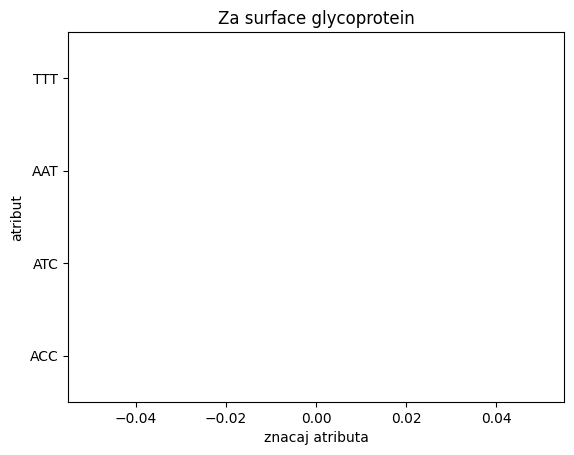

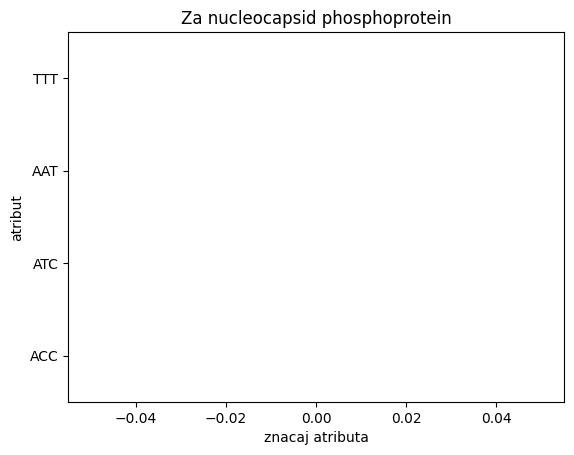

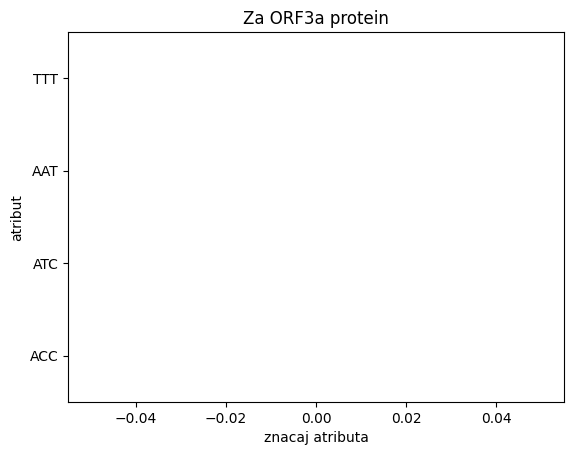

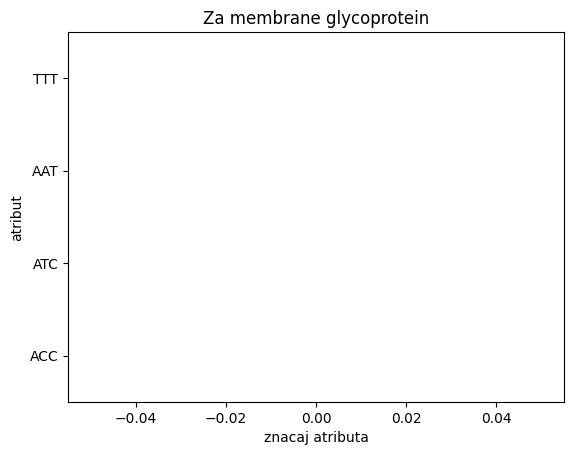

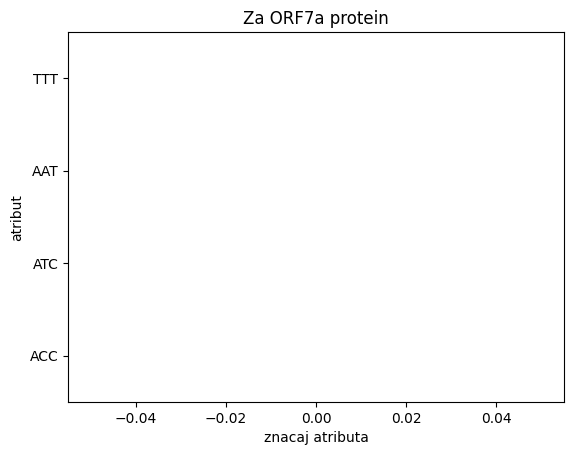

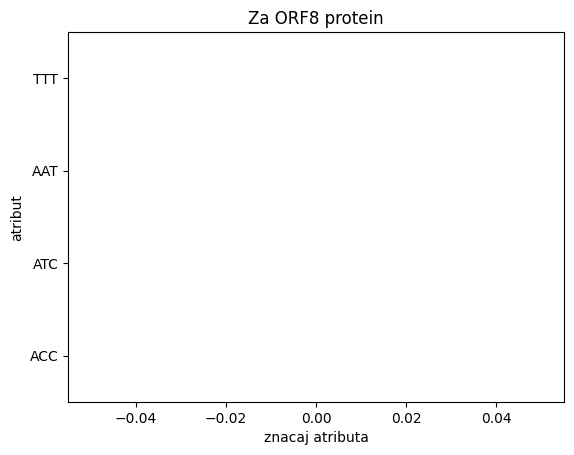

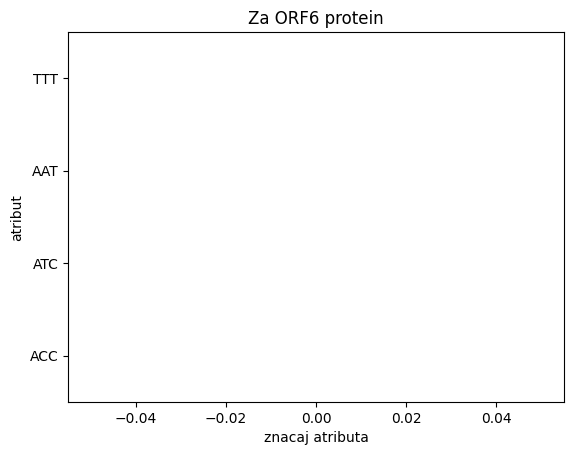

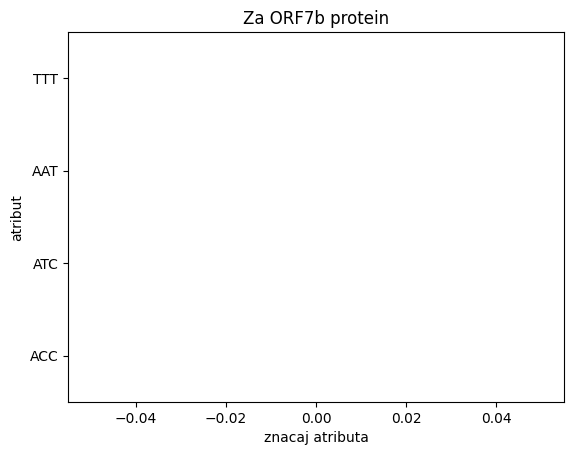

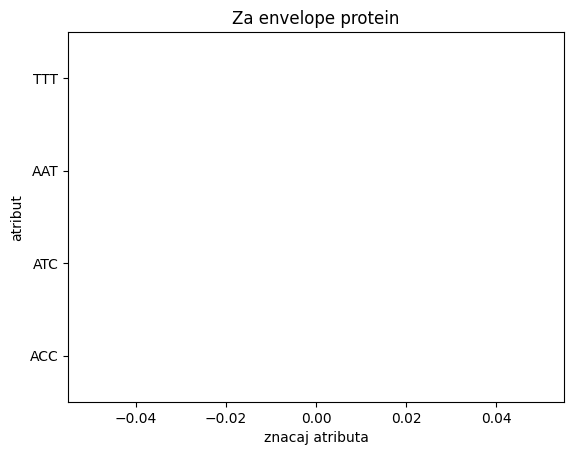

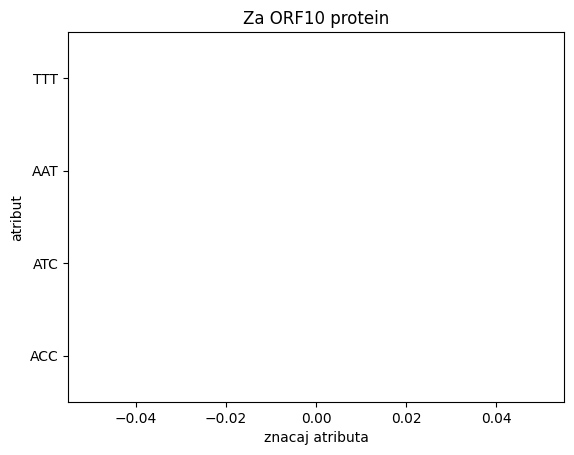

In [96]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke',
                         n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=32, n_jobs=2)

### Ekstremno gradijentno pojačavanje stabala odlučivanja

Slično opštoj metodi pojačavanja, klasifikacija se vrši iterativno, kombinacijom više slabih, potprilagođenih klasifikatora, da bi se dobio jedan moćan klasifikator.
Instancama koje klasifikator ne klasifikuje ispravno u trenutnoj iteraciji dodeljuje se veća težina.
Klasifikator u narednoj iteraciji obraća više pažnje na pravilno klasifikovanje instanci koje prethodno nisu bile ispravno klasifikovane.

Za razliku od ostalih algoritama pojačavanja, algoritam dozvoljava optimizaciju proizvoljne diferencijabilne funkcije cene i umesto gradijentnog spusta koristi Njutnovu metodu za optimizaciju funkcije cene.
Tejlorov razvoj drugog reda se koristi da bi se dobila veza funkcije cene i Njutnove metode.

Algoritam koristi stabla odlučivanja za slabe klasifikatore i implementiran je tako da se efikasno paralelizuje i iskoristi kapacitete savremenih računara.

Unakrsnom validacijom ćemo izabrati najbolji model varirajući broj klasifikatora, maksimalnu dubinu stabala odlučivanja i stopu učenja.

In [97]:
params = [{'n_estimators': [32, 64, 128],
           'max_depth': [2, 4],
           'learning_rate': [0.01, 0.1, 0.2],
           'objective': ['reg:linear'],
           'nthread': [-1],
           'random_state': [seed]}]

In [98]:
clf = GridSearchCV(XGBClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, enc.transform(y_train))

Ocena najboljeg klasifikatora je za nijansu slabija od klasifikatora iz nasumične šume. Razlika je u stotim delovima procenta.

In [99]:
clf.best_score_

0.9997906559182297

Parametri najboljeg modela.

In [100]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

learning_rate,max_depth,n_estimators,nthread,objective,random_state
0.100000,2,64,-1,reg:linear,196883


Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [101]:
y_true, y_pred = y_train, enc.inverse_transform(clf.predict(X_train))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

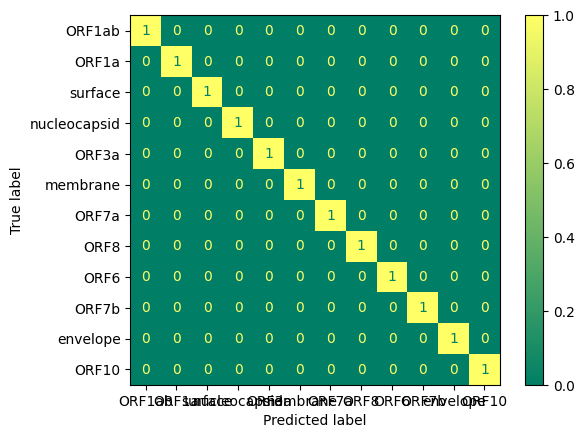

In [102]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

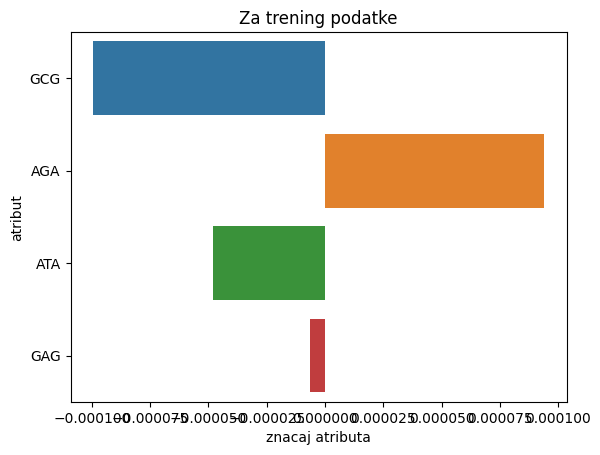

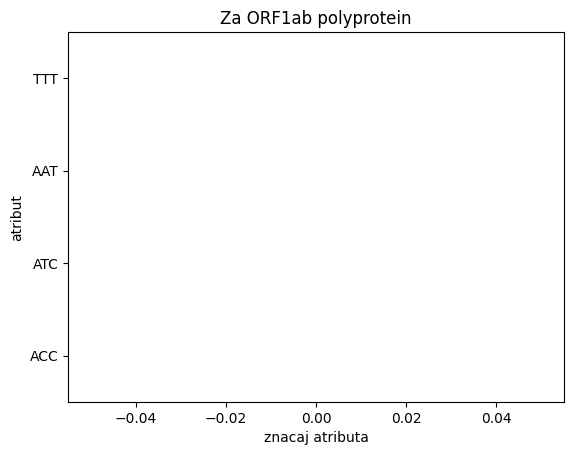

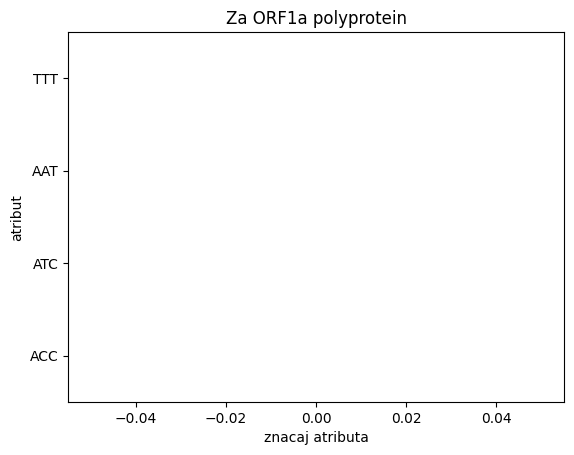

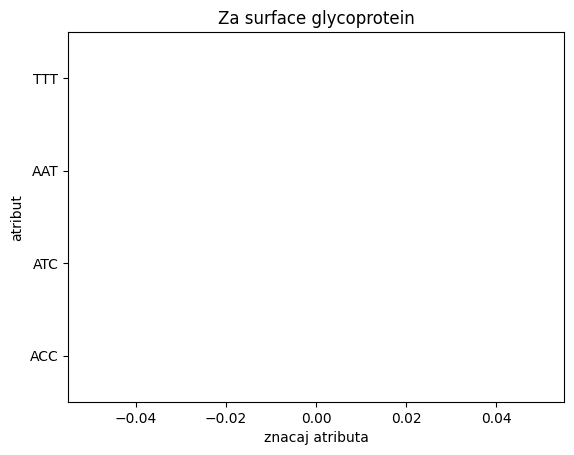

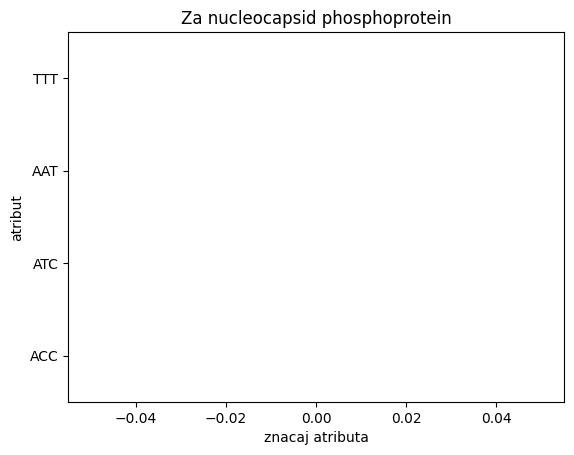

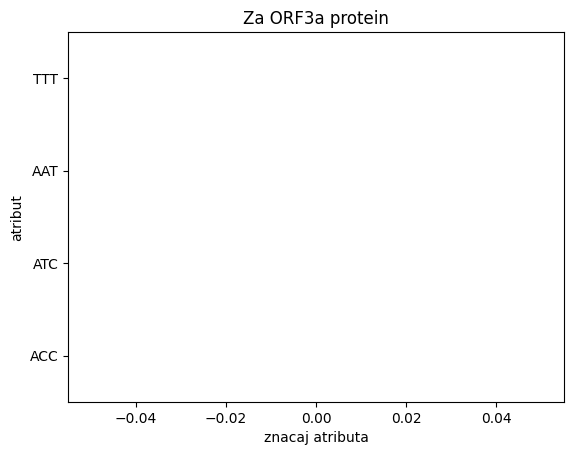

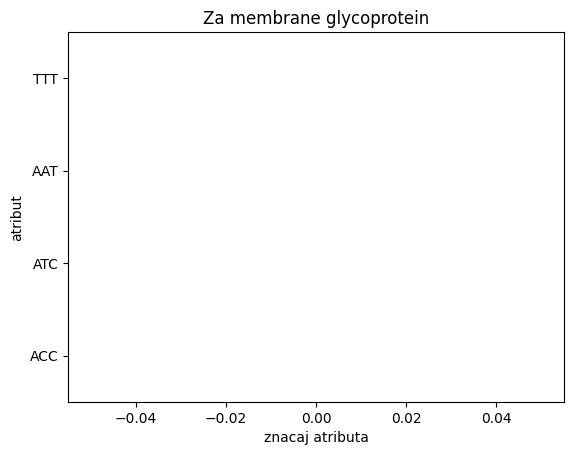

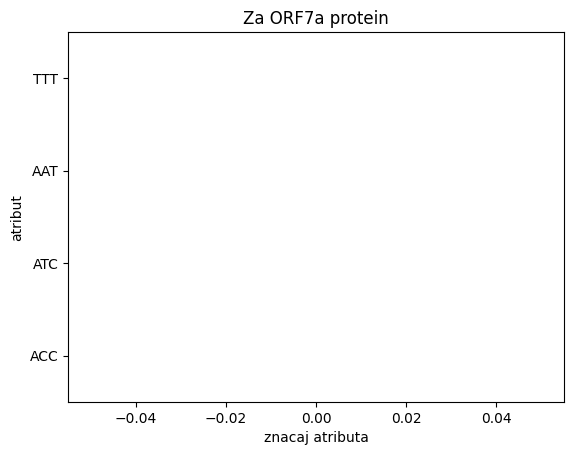

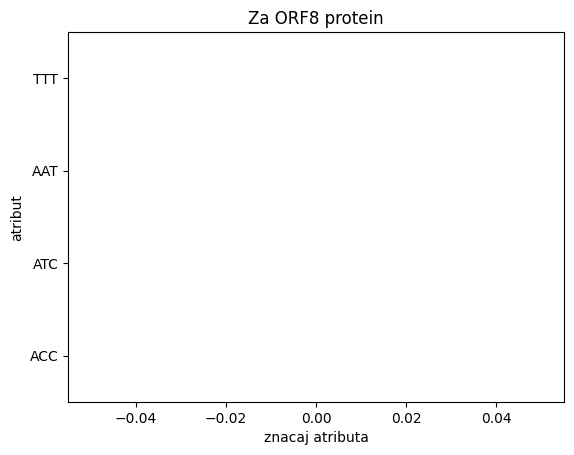

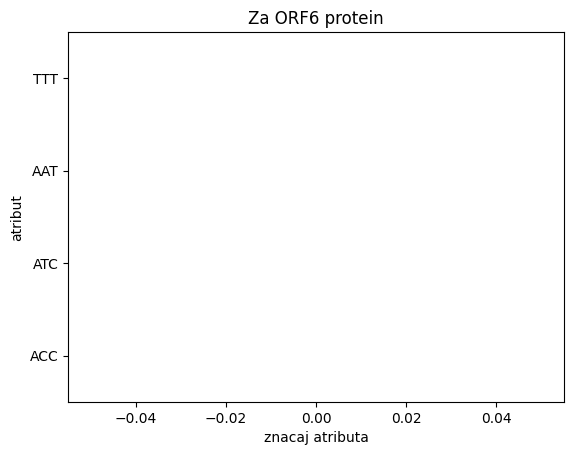

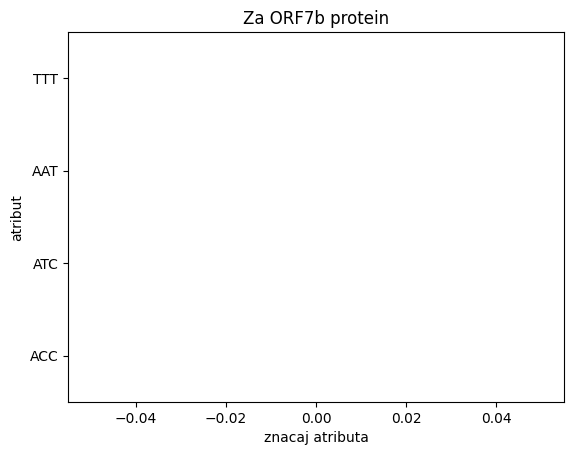

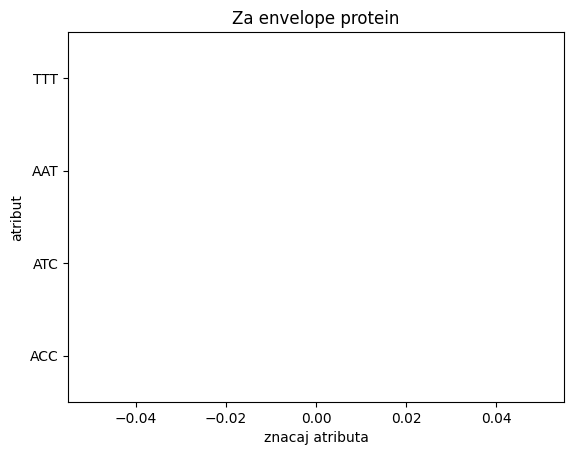

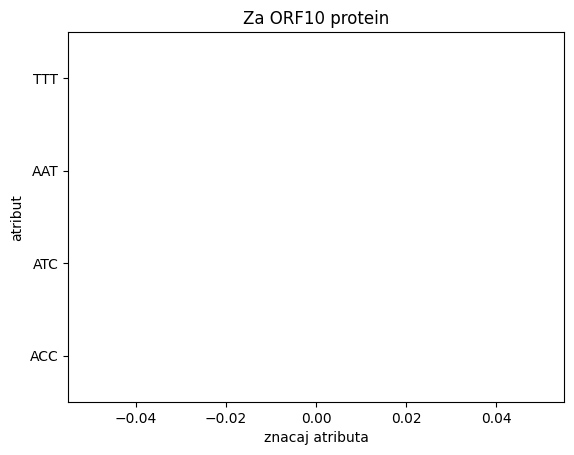

In [109]:
plot_feature_importances(clf, X_train, pd.Series(enc.transform(y_train), name='Protein'),
                         'Za trening podatke',
                         n_repeats=128, n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_train[y_pred == protein],
                             pd.Series(enc.transform(y_train[y_pred == protein]), name='Protein'),
                             f'Za {protein}',
                             n_repeats=128, n_jobs=2)

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [110]:
y_true, y_pred = y_test, enc.inverse_transform(clf.predict(X_test))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        1.00000    173972
                  macro avg    1

I ovaj model praktično klasifikuje bez greške.

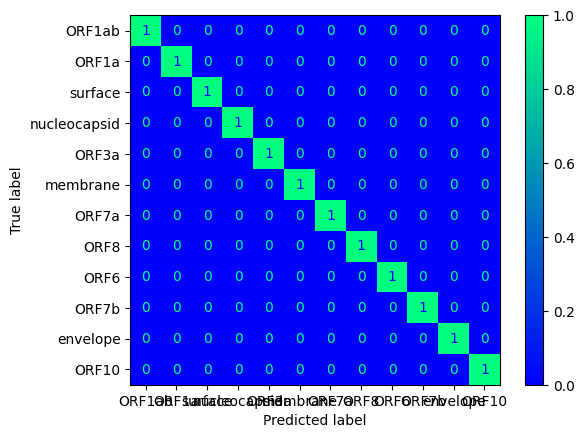

In [111]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

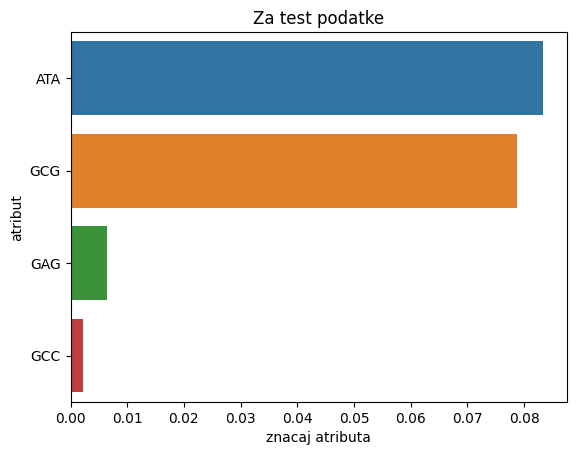

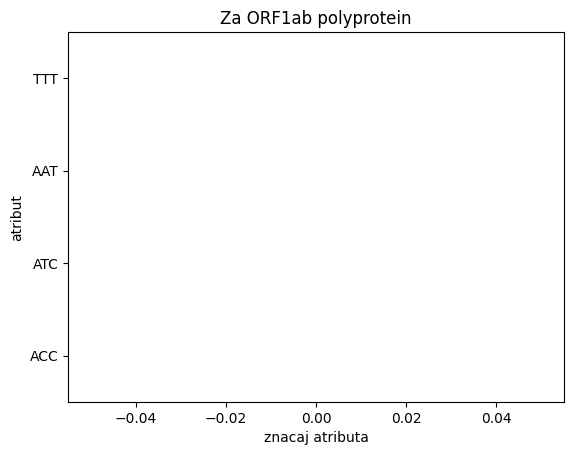

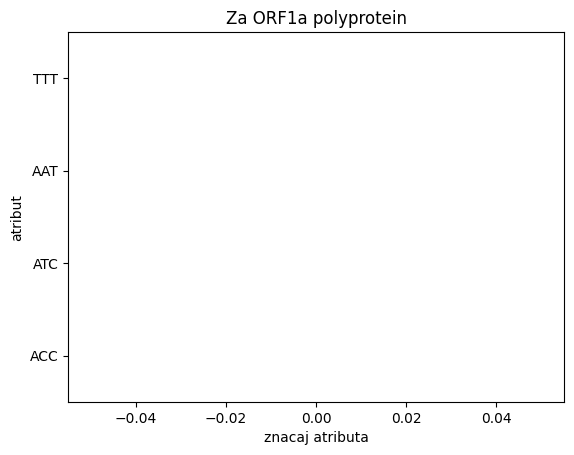

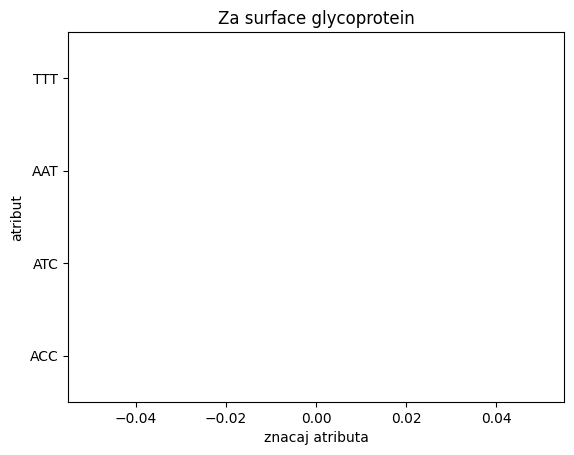

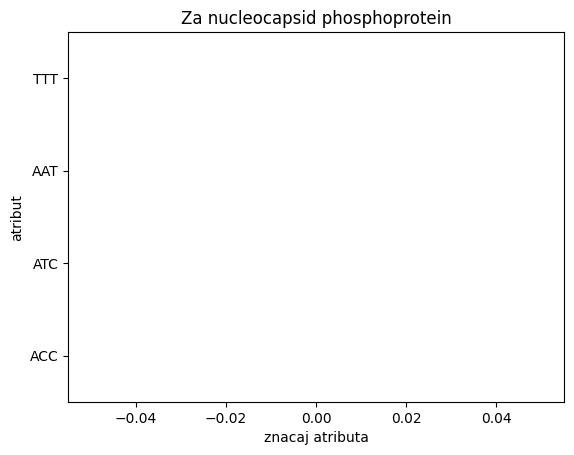

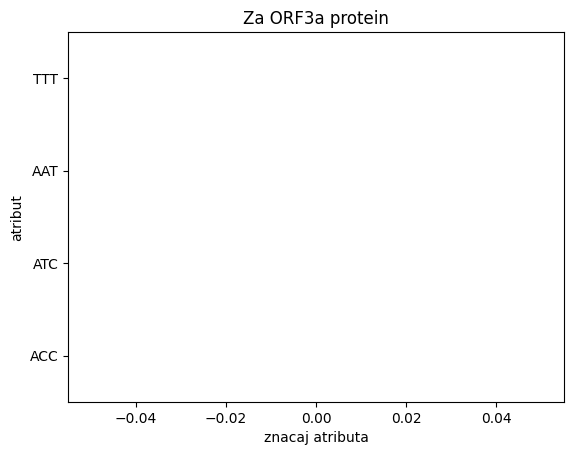

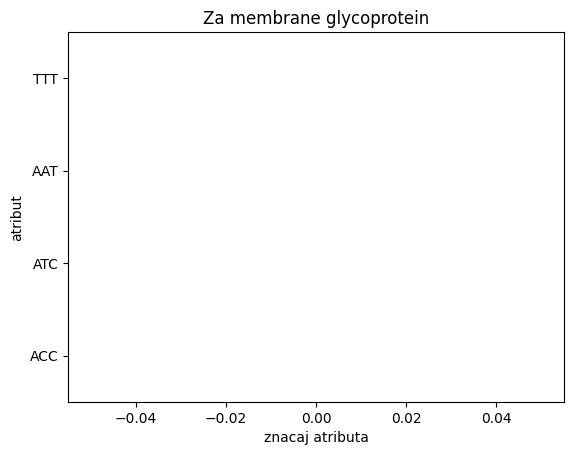

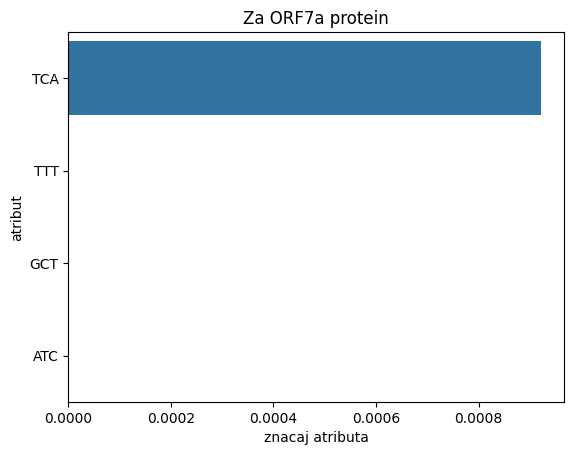

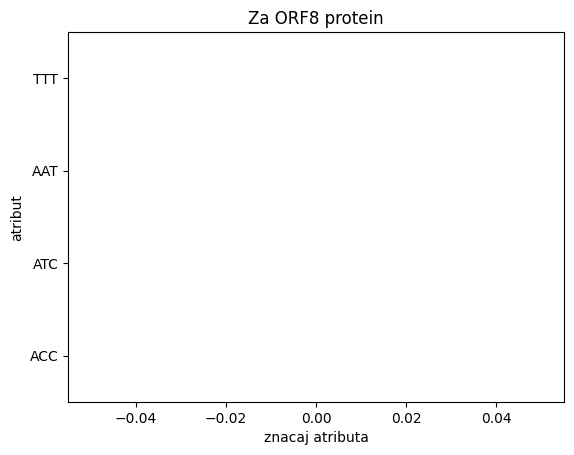

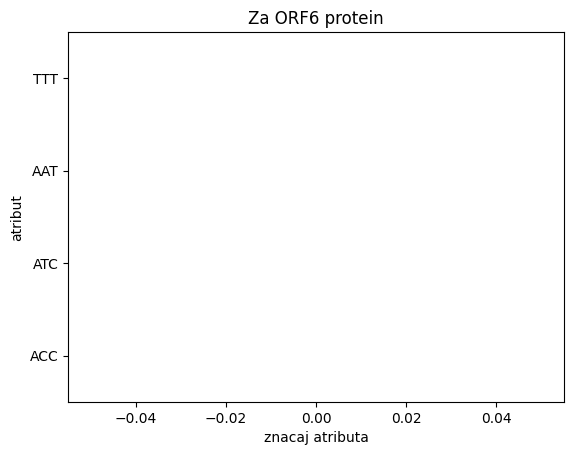

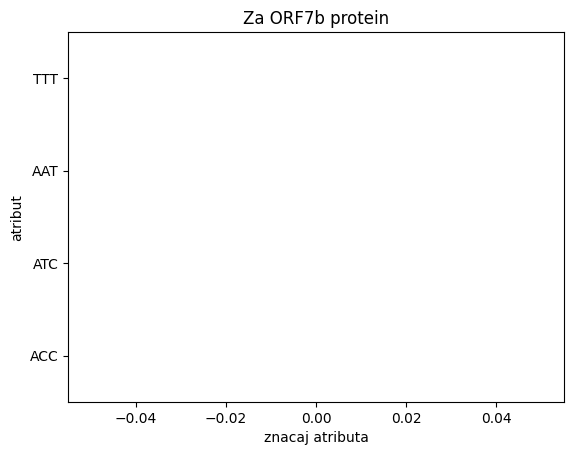

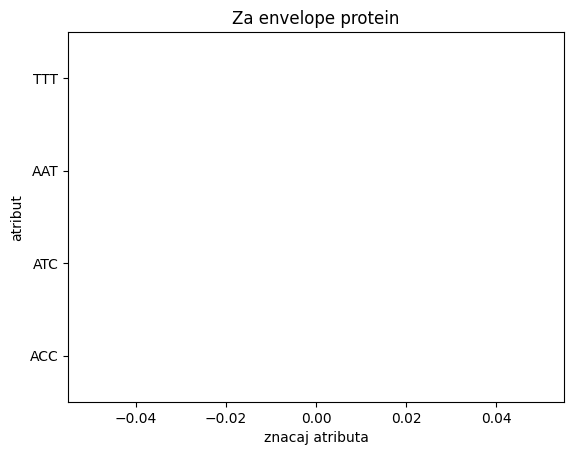

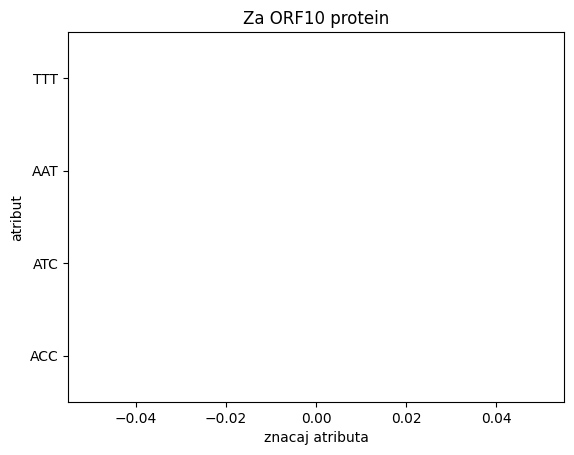

In [113]:
plot_feature_importances(clf, X_test, pd.Series(enc.transform(y_test), name='Protein'),
                         'Za test podatke',
                         n_repeats=128, n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             pd.Series(enc.transform(y_test[y_pred == protein]), name='Protein'),
                             f'Za {protein}',
                             n_repeats=128, n_jobs=2)

### K-najbližih suseda

Efikasnija implementacija osnovnog algoritma sa uniformnim težinama i Manhetn rastojanjem.

In [137]:
class FaissKNN:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def __sklearn_clone__(self):
        return self

    def get_params(self, deep=True):
        return {'k': self.k}
    
    def set_params(self, **params):
        self.index = None
        self.y = None
        self.k = params['k']

        return self

    def fit(self, X, y):
        self.index = faiss.IndexHNSWFlat(X.shape[1], 4224, faiss.METRIC_L1)
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        _, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [138]:
def calculate_permutation_importances(clf, X, y_true, y_pred, scoring):
    pi_list = []
    original_error = scoring(y_true, y_pred)
    for feature in range(X.shape[1]):
        perbutated_data = X.to_numpy(copy=True)
        np.random.shuffle(perbutated_data[:, feature])
        perbutated_pred = enc.inverse_transform(clf.predict(perbutated_data))
        perbutated_error = scoring(y_true, perbutated_pred)
        pi_list.append((original_error - perbutated_error))    
    return pd.DataFrame({'feature_name': X.columns, 'feature_importance': pi_list})

In [139]:
def plot_permutation_importances(df_pi, protein):
    ax = sns.barplot(df_pi.reindex(df_pi['feature_importance'].abs()
                                    .sort_values(ascending=False)
                                    .index).head(4),
                        x='feature_importance', y='feature_name')  # apsolutno opadajuce sortirani atributi
    ax.set(xlabel='znacaj atributa', ylabel='atribut')
    plt.title(protein)
    plt.show()

In [130]:
params = [{'k': [4, 8, 16, 32]}]

In [131]:
clf = GridSearchCV(FaissKNN(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train.to_numpy(), enc.transform(y_train))

In [132]:
clf.best_score_

0.9954410135835978

In [133]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

k
4


In [134]:
y_true, y_pred = y_train, enc.inverse_transform(clf.predict(X_train.to_numpy()))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.99176   0.99586       364
          ORF1a polyprotein    0.99994   1.00000   0.99997    241372
         ORF1ab polyprotein    0.99996   1.00000   0.99998    314439
              ORF3a protein    0.99989   1.00000   0.99995     18476
               ORF6 protein    0.99907   0.97541   0.98710      1098
              ORF7a protein    0.99975   1.00000   0.99987      3937
              ORF7b protein    0.99596   0.99462   0.99529       743
               ORF8 protein    1.00000   0.99843   0.99922      3831
           envelope protein    1.00000   0.99696   0.99848       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    0.99997   0.99973   0.99985     29103
       surface glycoprotein    0.99983   1.00000   0.99992     76782

                   accuracy                        0.99993    695886
                  macro avg    0

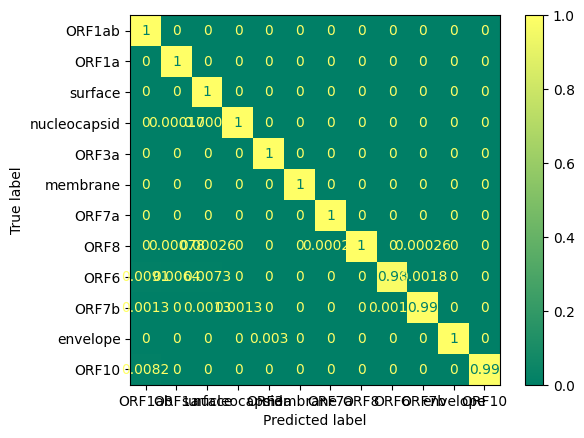

In [135]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

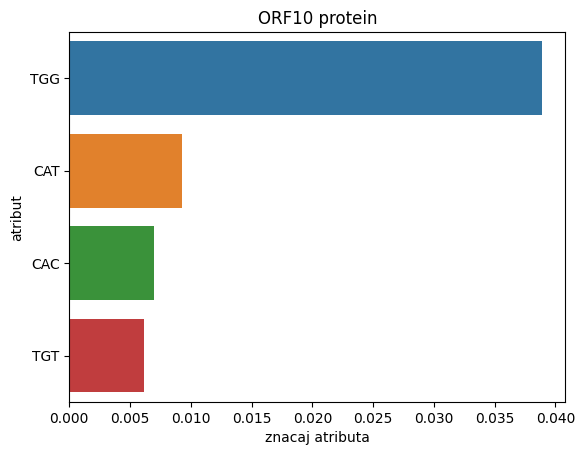

In [140]:
plot_permutation_importances(
    calculate_permutation_importances(clf,
                                      X_train,
                                      y_true,
                                      y_pred,
                                      balanced_accuracy_score),
    'Za trening skup')

for protein in protein_labels:
    plot_permutation_importances(
        calculate_permutation_importances(clf,
                                          X_train[y_pred == protein],
                                          y_true[y_pred == protein],
                                          y_pred[y_pred == protein],
                                          balanced_accuracy_score),
        f'Za {protein}')

In [141]:
y_true, y_pred = y_test, enc.inverse_transform(clf.predict(X_test.to_numpy()))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    0.99706   1.00000   0.99853     60343
         ORF1ab polyprotein    0.99995   1.00000   0.99997     78610
              ORF3a protein    0.99957   1.00000   0.99978      4619
               ORF6 protein    1.00000   0.93796   0.96798       274
              ORF7a protein    0.99898   1.00000   0.99949       984
              ORF7b protein    1.00000   0.97849   0.98913       186
               ORF8 protein    1.00000   0.84864   0.91813       958
           envelope protein    1.00000   0.98780   0.99387       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   0.99725   0.99862      7276
       surface glycoprotein    0.99984   1.00000   0.99992     19196

                   accuracy                        0.99892    173972
                  macro avg    0

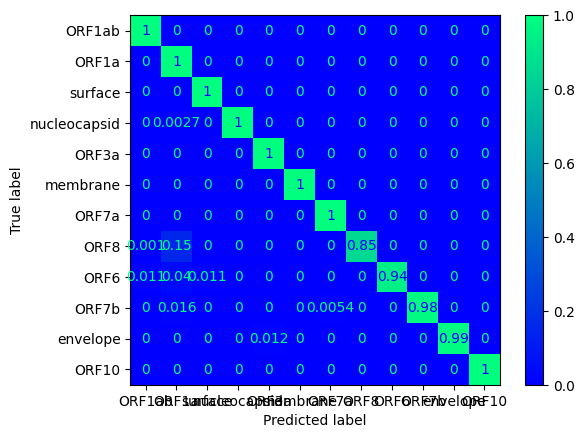

In [142]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

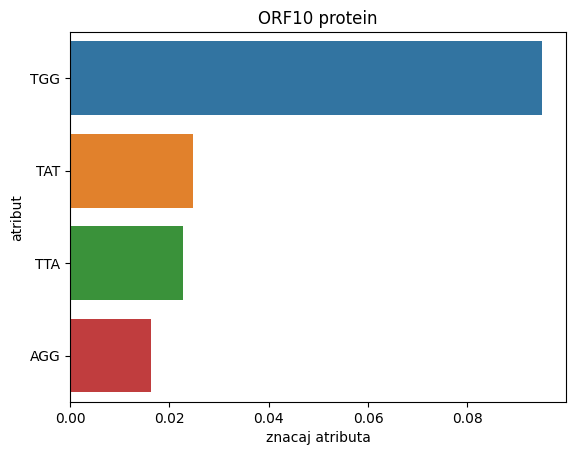

In [143]:
plot_permutation_importances(
    calculate_permutation_importances(clf,
                                      X_test,
                                      y_true,
                                      y_pred,
                                      balanced_accuracy_score),
    'Za trening skup')

for protein in protein_labels:
    plot_permutation_importances(
        calculate_permutation_importances(clf,
                                          X_test[y_pred == protein],
                                          y_true[y_pred == protein],
                                          y_pred[y_pred == protein],
                                          balanced_accuracy_score),
        f'Za {protein}')

### Linearna mašina sa potpornim vektorima

Već smo dobili dva modela koji praktično ne greše.
Da bi zadovoljili radoznalost, napravićemo još jedan.

Algoritam traži hiperravni koje razdvajaju podatke na klase.
Tražimo najbolje parametre za regularizaciju i skaliranje.
Prosleđujemo argument kojim ukazujemo algoritmu da klasama dodeli težine.
Na taj način rešavamo problem neuravnoteženosti podataka.

Parametar za regularizaciju utiče na cenu pogrešno klasifikovane instance.
Što je parametar veći, mogel će oštrije ocenjivati nepravilno klasifikovane instance.
Što je parametar manji, model će više tolerisati nepravilno klasifikovane instance.
Parametar se ponaša kao neka vrsta dozvoljene margine, koliko daleko podaci mogu da se nalaze sa pogrešne strane hiperravni.

Algoritam interno vrši standardizaciju podataka.
U te svrhe koristi i parametar skaliranja.
To je multiplikativni faktor i utiče na težinu atributa prilikom ocenjivanja nepravilno klasifikovane instance.

In [116]:
params = [{'dual': [True],
           'C': [0.1, 1, 10, 100],
           'intercept_scaling': [0.01, 0.1, 1, 10],
           'class_weight': ['balanced'],
           'max_iter': [2147483647],
           'random_state': [seed]}]

In [117]:
clf = GridSearchCV(LinearSVC(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Najbolji dobijeni model ima nešto slabiju ocenu od metode ansambla, ali bolju od stabla odlučivanja.

In [118]:
clf.best_score_

0.9996995287026339

Parametri najboljeg modela.

In [119]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

C,class_weight,dual,intercept_scaling,max_iter,random_state
1,balanced,True,1,2147483647,196883


Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [120]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

Impresivan rezultat.

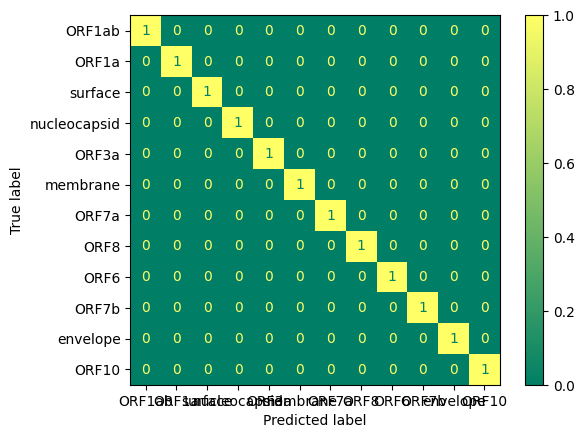

In [121]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='summer')
plt.show()

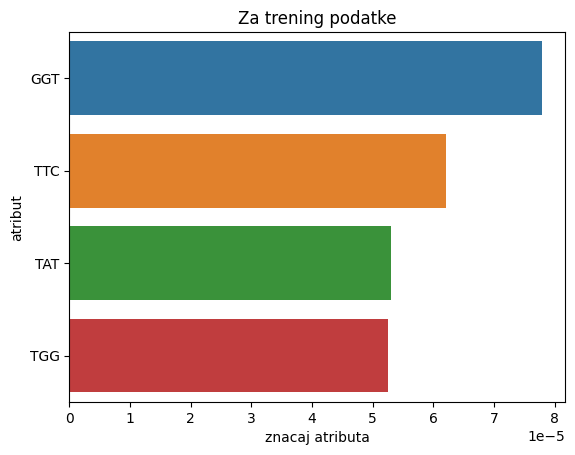

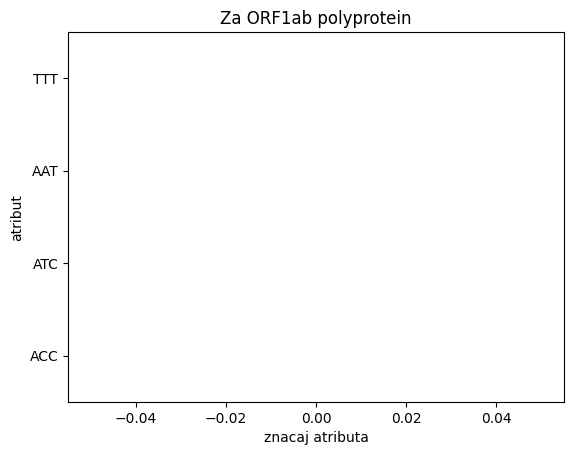

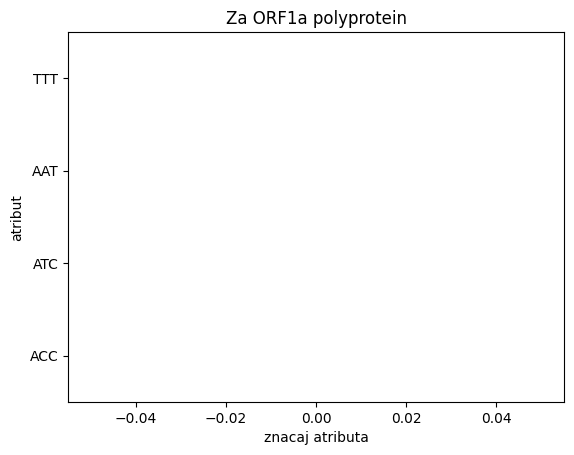

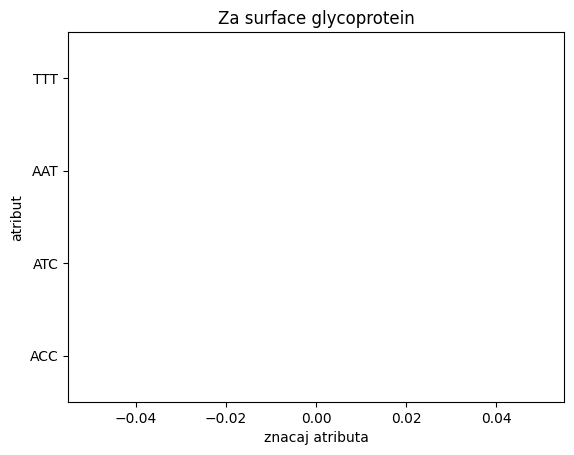

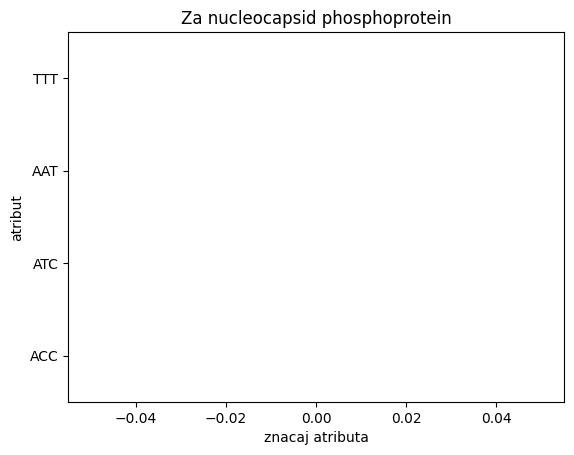

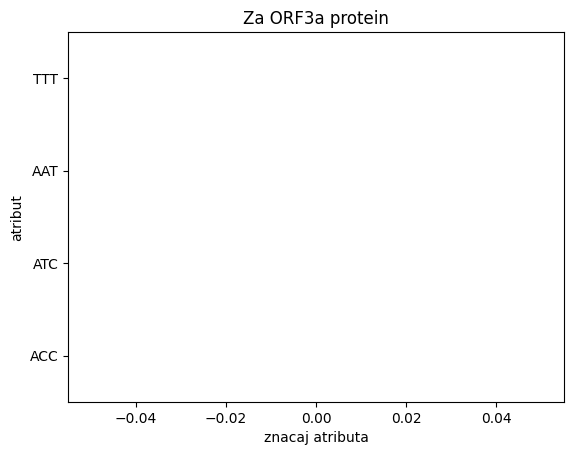

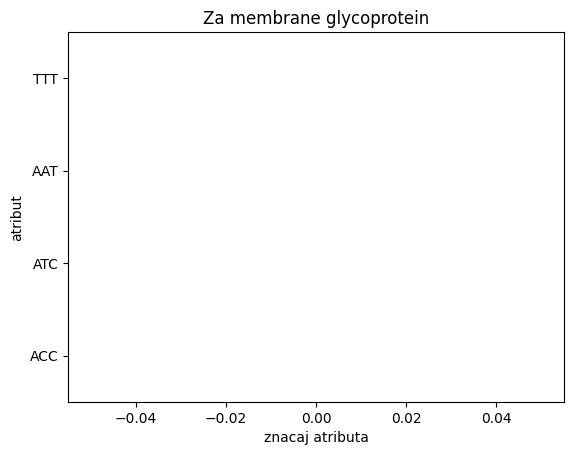

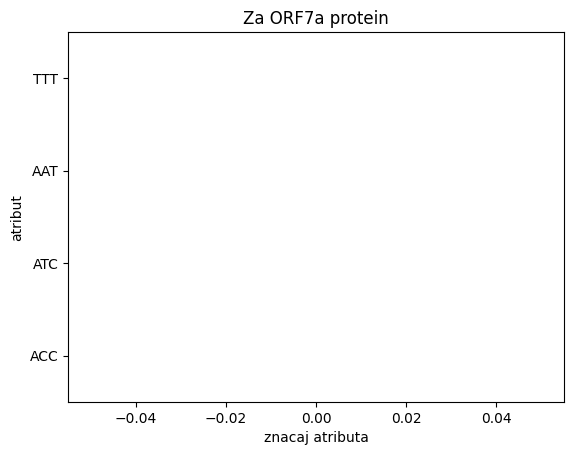

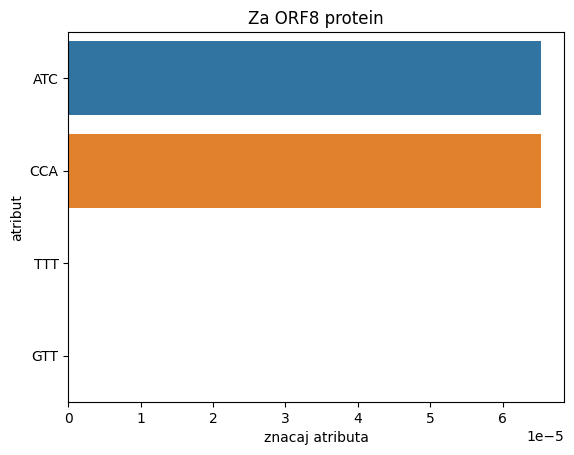

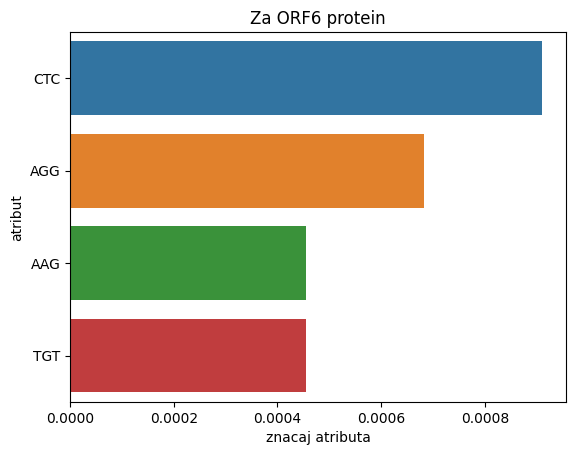

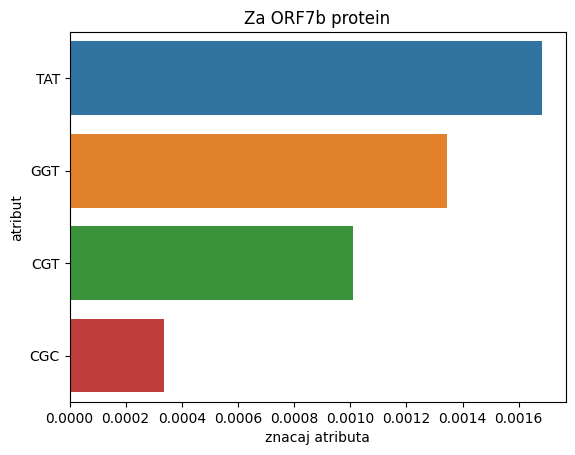

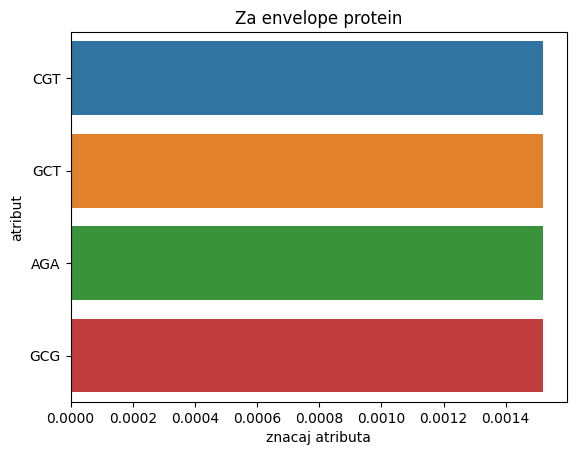

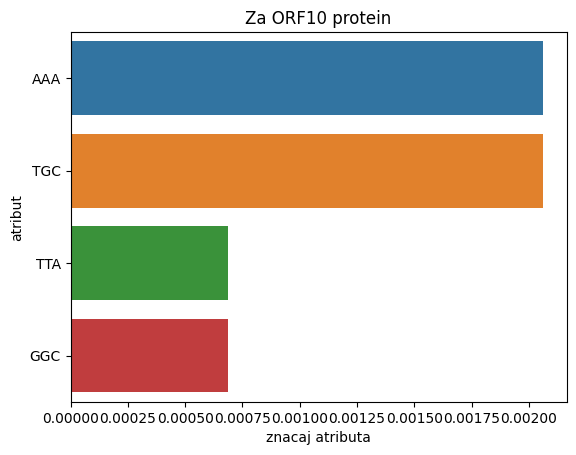

In [122]:
plot_feature_importances(clf, X_train, y_train,
                         'Za trening podatke',
                         n_repeats=128, n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_train[y_pred == protein],
                             y_train[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=128, n_jobs=-1)

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [123]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.98901   0.99448        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    0.99999   1.00000   0.99999     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        0.99999    173972
                  macro avg    1

Model je blago preprilagođen.
Pogrešno klasifikuje deo instanci *ORF10* proteina kao *ORF1ab* protein.

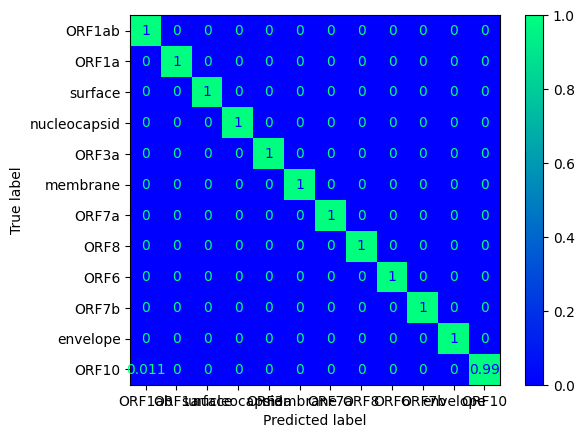

In [124]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

fig.plot(cmap='winter')
plt.show()

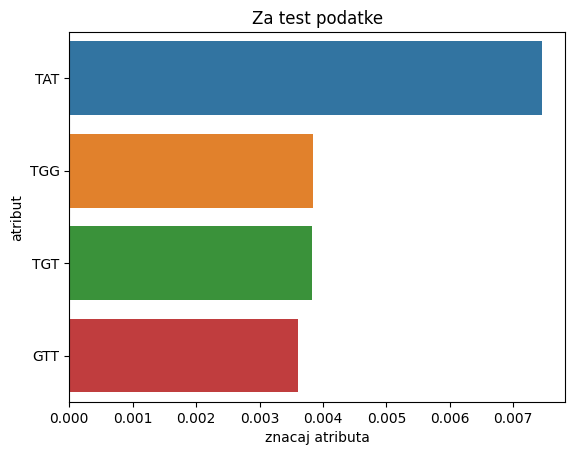

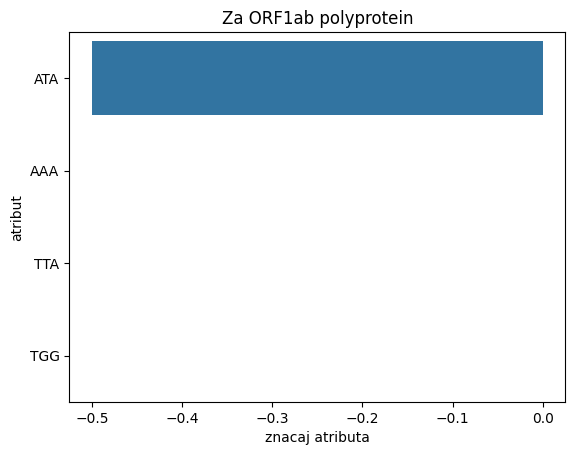

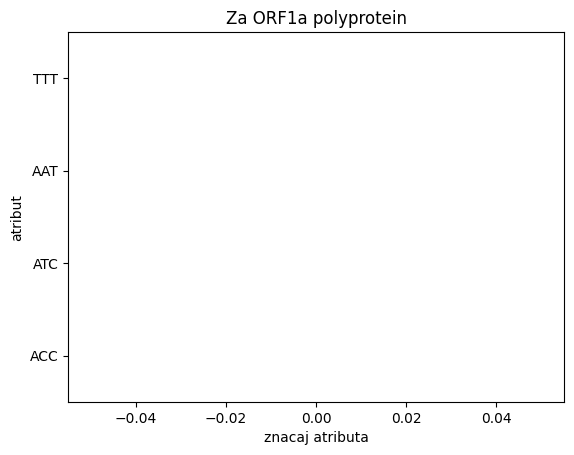

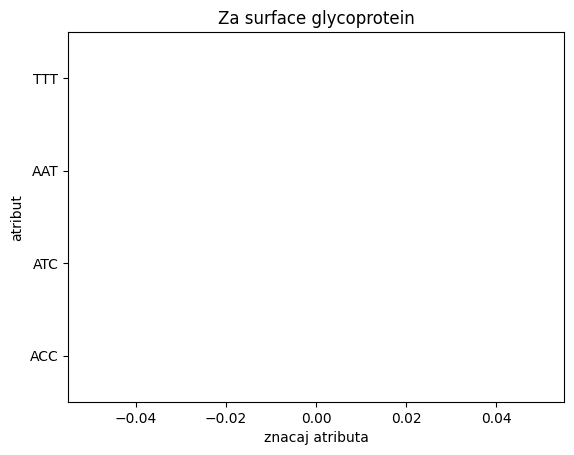

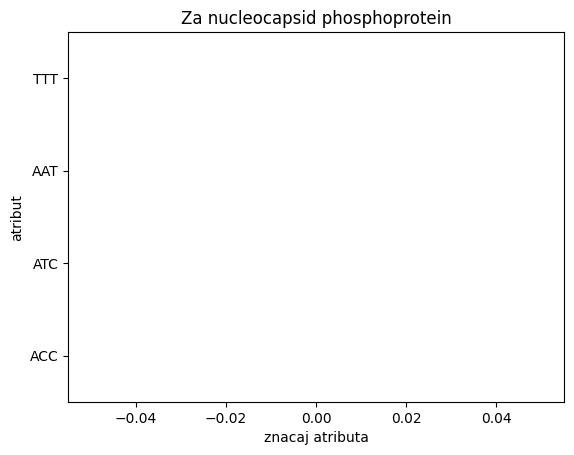

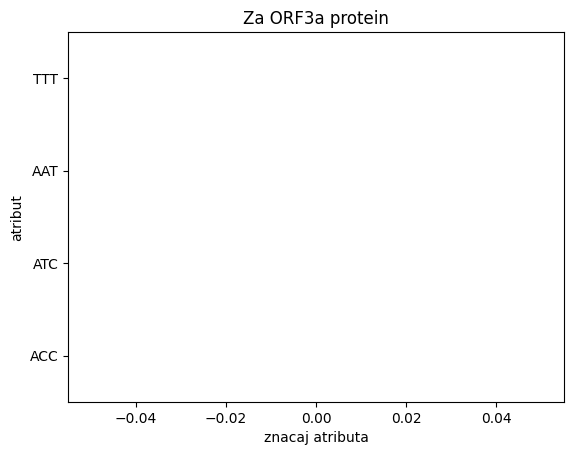

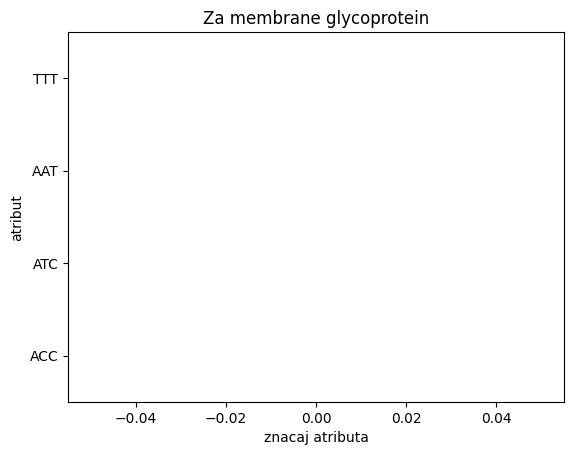

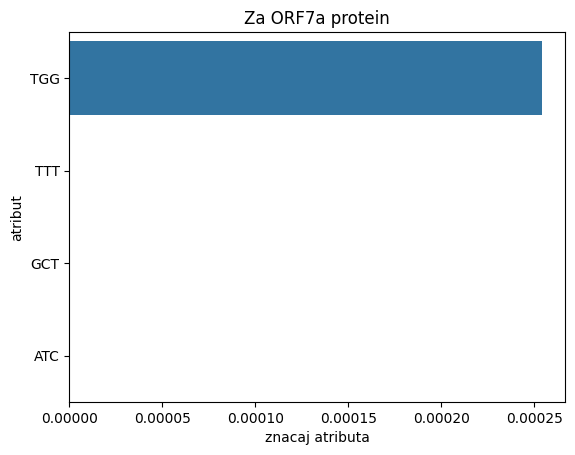

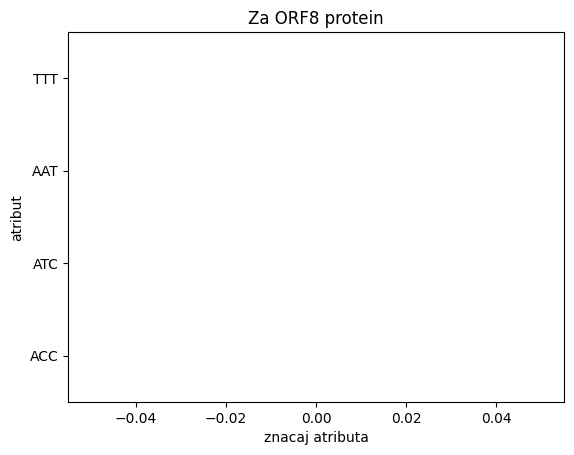

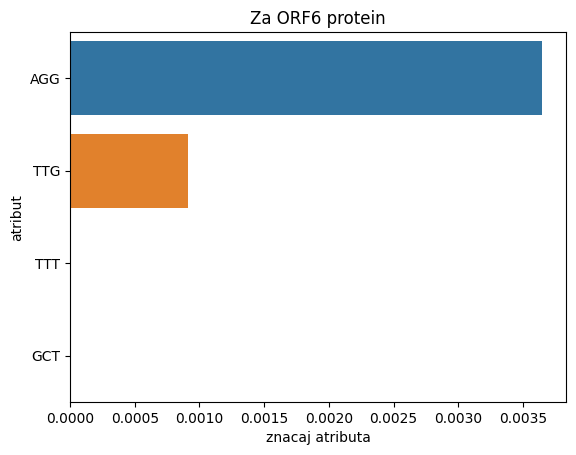

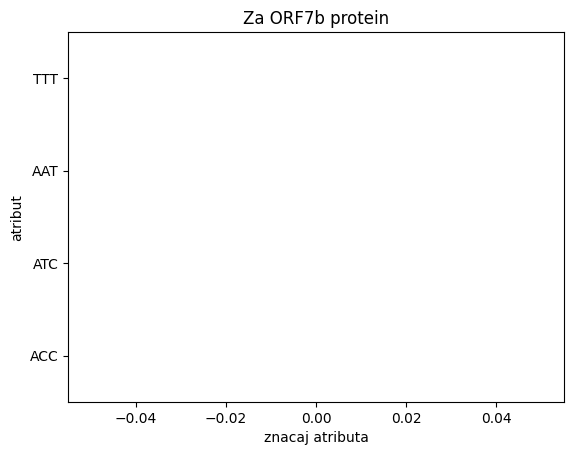

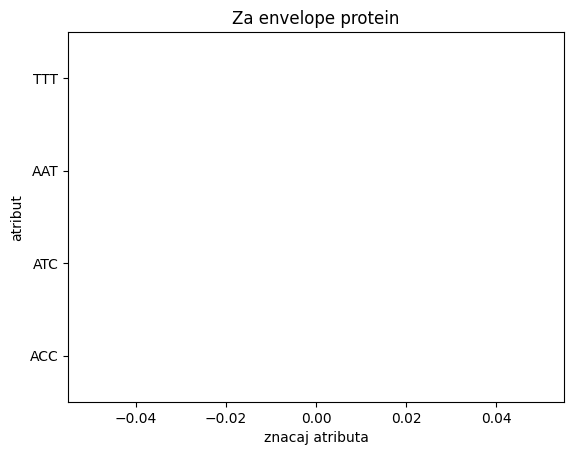

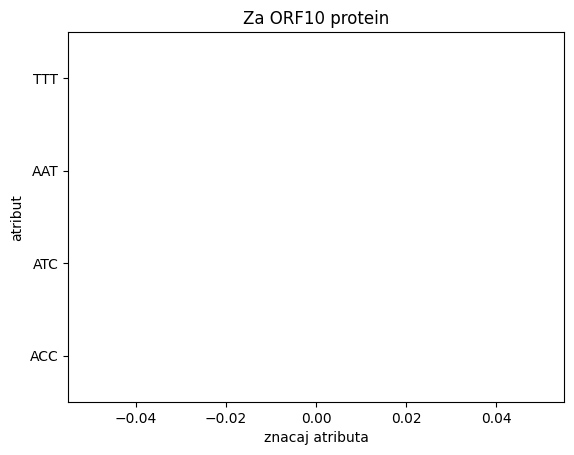

In [125]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke',
                         n_repeats=128, n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             n_repeats=128, f'Za {protein}', n_jobs=-1)

## Zaključak

Najbolje rezultate su postigle metode ansambla *nasumična šuma* i *ekstremno gradijentno pojačavanje*.
Ove dve metode su dale modele koji praktično savršeno klasifikuju, kako instance iz trening skupa, tako i instance iz test skupa.
Klasifikator dobijen metodom *nasumične šume* se sastoji iz 128 preprilagođenih stabala, dok klasifikator dobijen *ekstremnim gradijentnim pojačavanjem* se sastoji iz 64 potprilagođena stabla dubine 2, pa bi mogli reći da je dobijeni model jednostavniji.
Sa druge strane algoritmi ansambla zasnovani na pojačavanju po pravilu zahtevaju više vremena u trening fazi, jer je sam proces iterativan.

Premda metode ansambla daju bolje klasifikatore, oni su manje pogodni za interpretaciju.
Ybog postupnosti, algoritam pojačavanja bi mogao da se interpretira, korak po korak.
No analiza ponašanja 64 stabla koja sekvencijalno vrše klasifikaciju može da bude zamoran posao.
Zato ih posmatramo kao crne kutije i ocenjujemo ih na osnovu rezultata klasifikacije.

Zatim sledi *mašina sa potpornim vektorima*, koja je takođe savršeno klasifikovala instance iz trening skupa skupa, ali na test skupu $1\%$ instanci koje pripadaju klasi *ORF10* proteina su klasifikovane kao *ORF1ab* protein.
Zbog toga kažemo da je model blago preprilagođen.
Problem sa *ORF10* proteionom je veoma malo zastupljen u podacima i uprkos tome što smo klasama dodelili težine na osnovu njihove zastupljenosti u podacima, ne iznenađuje što kvalitet klasifikacije opada kod klase za koju imamo malo podataka.

Teoretski posmatrano, mašina sa potpornim vektorima bi trebalo da daje interpretabilne modele.
Možemo da projekujemo podatke i hiperravan na dve ose i posmatramo gde je margina i kako su podaci razdvojeni.
Međutim, sam broj dimenzija u našim podacima otežava interpretaciju ovog modela.
Postavljaju se pitanja, kako projektovati podatke?
Koje ose izabrati?
Pokušavajući da odgovorimo na ta pitanja dolazimo do kombinatorne eksplozije mogućnosti.

Algoritam *CART* je takođe dao rezultat kakvog se ne bi stideli ni jači klasifikatori.
Po klasama, dobijeni model klasifikuje preko $99\%$ instanci ispravno, kako na trening, tako i na test skupu.
Međutim, neke greške ipak postoje.
Te greške deluju dosta nasumično, tako da ne možemo reći da su izazvane neuravnoteženošću podataka.
Jednostavno, to je najbolje što ovaj klasifikator može da postigne sa ovim podacima, što uopšte nije loše.

Bez obzira na visoku dimanzionalnost podataka, stabla odlučivanja daju modele koji se jednostavno mogu interpretirati.
Dobijeni model možemo predstaviti grafički i jednostavno analizirati model, znajući tačno kako će svaka instanca biti klasifikovana.

U poređenju sa metodama ansambla, faza treniranja za *stablo odlučivanja* i *mašinu sa potpornim vektorima* je bila znatno brža.

Konačno, naivni Bajesov algoritam nije proizveo klasifikator prihvatljivih performansi.
Iako bi trik sa računanjem komplemenata trebalo da otkloni problem sa nauravnoteženih podataka, dobijeni model je ispravno klasifikovao samo instance samo 5 najzastupljenijih klasa, dok je instance ostalih klasa potpuno pogrešno klasifikovao, sa izuzetkom za proteina *ORF7a* i *ORF8*, gde je takođe pravio velike greške.
Čak ni u metodi pakovanja naivni Bajesov algoritam nije dao bolje rezultate.

Prilikom ocenjivanja modela dobijenog naivnim Bajesovim algoritmom mogli smo da primetimo da nisu sve metrike jednako pogodne za neuravnotežene podatke.
Primenom metrike tačnost, model je dobio ocenu $0.99$, što znači da model klasifikuje $99\%$ instanci ispravno.
No ta metrika posmatra ukupan broj ispravno klasifikovanih instanci u odnosu na ukupan broj instanci, bez obzira kojoj klasi pripadaju.
To daje veoma nepreciznu ocenu, posebno u slučaju kada $79\%$ instanci su predstavnici dve od dvanaest klasa.

Najbolji način da se prevaziđe problem neuravnoteženosti podataka je da se uzme još uzoraka za one klase koje nedostaju.
U našem slučaju, to bi bilo dodadtno sekvenciranje gena i proteina.
Taj način je skup i zahteva dosta vremena.
Mi pravimo klasifikatore da upravo to ne bi morali da radimo.

Drugi način bi bio da na neki način generišemo podatke iz manje zastupljenih klasa i iskoristimo ih za obučavanje modela.
Ta metoda je sama po sebi kompromis.
Mi ne znamo da u kojoj meri bi generisani podaci bili reprezentativni.

Treći način bi bio da odbacimo deo podataka iz zastupljenijih klasa i tako uravnotežimo podatke.
Uslovno govoreći, ti podaci ne bi bili generički, ali time bi globalno smanjili kvalitet podataka i pitanje je koliko bi klasifikator dobijen sa tim podacima bio relevantan u praksi.

Imajući u vidu da smo sa postojećim podacima, primenjujući druge algoritme, već dobili veoma dobre modele, nema potrebe da sprovodimo intervencije koje bi mogle da kompromituju podatke, samo da bi pomogli slabijem klasifikatoru da napravi bolji model.